# Imports set up rendering

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ['MUJOCO_GL'] = 'egl'
os.environ['PYOPENGL_PLATFORM'] = 'egl'
os.environ["XLA_FLAGS"] = "--xla_gpu_triton_gemm_any=True"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use GPU 0

# JAX setup
import jax
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
# Note: jax_persistent_cache_enable_xla_caches may not be available in all JAX versions
try:
    jax.config.update("jax_persistent_cache_enable_xla_caches", "xla_gpu_per_fusion_autotune_cache_dir")
except AttributeError:
    pass  # Skip if not available in this JAX version
jax.config.update("jax_default_matmul_precision", "high")


In [2]:
%load_ext autoreload
%autoreload 2
from notebook_setup import *

Added /home/eabe/Research/MyRepos/fly_neuromechanics/RL_training to Python path


✅ Project modules imported successfully
✅ Notebook setup complete


# Load configs

In [4]:
dataset = 'fly_imitation'
version = 'walk'
# base_dir = Path(f'/gscratch/portia/eabe/biomech_model/Flybody/{dataset}/{version}')
# base_dir = Path(f'/data/users/eabe/biomech_model/Flybody/{dataset}/{version}')
base_dir = Path(f'/data2/users/eabe/fly_neuromech/{version}')
run_cfg_list = natsorted(list(Path(base_dir).rglob('run_config.yaml')))
for n, run_cfg in enumerate(run_cfg_list):
    temp = OmegaConf.load(run_cfg)
    print(n, temp.dataset.name, temp.version, run_cfg)

# ###### Load and update config with specified paths template ###### 

cfg_num = -1

# NEW APPROACH: Load config a"nd replace paths using workstation.yaml template
cfg = load_config_and_override_paths(
    config_path=run_cfg_list[cfg_num],
    new_paths_template="default",    # Use workstation.yaml for local paths
    config_dir=Path.cwd().parent / "configs",
)

print(f'✅ Loaded experiment: {cfg.dataset.name}')

# Convert string paths to Path objects and create directories
# cfg.paths = convert_dict_to_path(cfg.paths)
print("✅ Successfully converted all paths to Path objects and created directories")

##### Load reference data and split into train/test #####
# reference_path = cfg.paths.data_dir/ f"clips/{cfg.dataset.clip_idx}"
# reference_clips = ReferenceClips.from_path(reference_path, enable_jax=True)
# ref_train, ref_test = reference_clips.split(test_ratio=0.2)
# print(f"✅ Loaded reference data from {reference_path}")


0 fly_imitation_descending walk /data2/users/eabe/fly_neuromech/walk/test_001/logs/run_config.yaml
✅ Loaded experiment: fly_imitation_descending
✅ Successfully converted all paths to Path objects and created directories


# Clean walking data processing

In [ ]:
# cfg.dataset.env_args.mjcf_path='/home/eabe/Research/MyRepos/Fly_tracking/assets/fruitfly_v2/fruitfly_v2_clean.xml'
# cfg.dataset.env_args.mjcf_path='/home/eabe/Research/MyRepos/Fly_tracking/assets/fruitfly/fruitfly_v1.xml'
env = imitation.Imitation(cfg, reference_clips=reference_clips)

In [5]:
import pandas as pd
base_path = Path('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/')
data_path = base_path / 'combined_wt_berlin_walking_v3.pq'

full_df = pd.read_parquet(data_path, engine='pyarrow')

legs = ['T1_left', 'T1_right', 'T2_left', 'T2_right', 'T3_left', 'T3_right']
joints = ['coxa', 'femur', 'tibia', 'tarsus']
xpos_geoms = ['coxa', 'femur', 'tibia', 'tarsus', 'claw']
joint_names = [f'{joint}_{leg}' for leg in legs for joint in joints]
xpos_names = [f'{joint}_{leg}' for leg in legs for joint in xpos_geoms]
site_names = [f'tracking[{joint_name}]' for joint_name in xpos_names]

legs_data = ['L1', 'R1', 'L2','R2', 'L3','R3']
joints_data = ['A','B','C','D','E']
coords_data = ['_x','_y','_z']
joint_pos_columns = [leg + joint + coord 
                     for leg in legs_data
                     for joint in joints_data 
                     for coord in coords_data]

def transform_bout(bout):
    """Transform a single frame from data to model reference frame."""
    # Rotate around z-axis.
    bout = bout[:, :, [1, 0, 2]]
    bout[:,:, 1] *= -1
    # bout = bout - bout[:,:1,:]
    # Change units mm to cm.
    bout *= 0.1
    return bout

all_bout_nums = full_df['walking_bout_number'].unique()[1:]
bout_dict = {'walking_bout{:04}'.format(n):{} for n in range(len(all_bout_nums))}
for n, bout_num in enumerate(tqdm(all_bout_nums)):
    bout = full_df[full_df['walking_bout_number'] == bout_num]
    # kp_data = transform_bout(bout[joint_pos_columns].values.reshape(-1,30, 3))
    # bout_dict['walking_bout{:04}'.format(n)]['orig_kp'] = kp_data
bout_dict = ioh5.load('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/New_aligned_Walking_V2_avg.h5')

# clip_lengths = np.stack([bout_dict[key]['clipped_xpos'].shape[0] for key in bout_dict.keys()])

  0%|          | 0/1729 [00:00<?, ?it/s]

In [6]:
# spec = mujoco.MjSpec().from_file('/home/eabe/Research/MyRepos/Fly_tracking/assets/fruitfly_v1/fruitfly_v1.xml')
# /home/eabe/Research/MyRepos/fly_neuromechanics/fruitfly_body_models/fruitfly_v2.1/fruitfly_v2.1_muscles.xml')
# mj_model = spec.compile()
flybody_path = Path(cfg.physics.mjcf_path)
arena_path = Path(cfg.physics.arena_path)
spec = mujoco.MjSpec().from_file(flybody_path.as_posix())
floor_spec = mujoco.MjSpec().from_file(arena_path.as_posix())
spawn_frame = floor_spec.worldbody.add_frame(
                pos=[0,0,0],
                quat=[1,0,0,0],
            )
spawn_body = spawn_frame.attach_body(spec.body("thorax"), "", suffix='_fly')

mj_model = floor_spec.compile()
mj_data = mujoco.MjData(mj_model)

# mj_model = env.mj_model
# spec = env._spec
data = mujoco.MjData(mj_model)
site_names = [site.name for site in spec.sites if 'tracking' in site.name]
site_idxs = jnp.array([site.id for site in spec.sites if 'tracking' in site.name])
len(site_names)

0

In [ ]:

mj_data = mujoco.MjData(mj_model)

mujoco.mj_forward(mj_model, mj_data)
ref_pose = mj_data.site_xpos[site_idxs]
print('Aligning to zero at ref_pose:', ref_pose[0], site_names[0])
ref_pose = ref_pose - ref_pose[0]


    
fly_clrs = [
    [[0.22, 0.46, 0.67]],
    [[0.76, 0.21, 0.17]],
    [[0.92, 0.5, 0.18]],
    [[0.55, 0.41, 0.72]],
    [[0.32, 0.62, 0.24]],
    [[0.51, 0.34, 0.30]],
]

clrs_tr = [
    '#ff4081ff',
    '#1e90ffff',
    '#8b4513ff',
    '#ff4081ff'
    ]



In [ ]:
from utils import io
# stac_path = Path('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/Fruitfly_V2_ik_fast_simple_avg.h5')
# stac_path = Path('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/Fruitfly_ik_V1_full.h5')
# stac_path = Path('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/Fruitfly_V2_ik_clean.h5')
# stac_path = Path('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/Fruitfly_V1_ik.h5')
stac_path = Path('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/Fruitfly_V2.1_mu_ik.h5')


cfg_d, d = io.load_stac_data(stac_path.as_posix())
mocap_qpos = d.qpos
mocap_xpos = d.xpos
kp_data = d.kp_data
kp_names = d.kp_names
offsets = d.offsets

mocap_qpos.shape

(3902353, 88)

In [ ]:
n_clips = len(bout_dict)
mocap_qpos = mocap_qpos.reshape(n_clips, -1, mocap_qpos.shape[-1])
mocap_xpos = mocap_xpos.reshape(n_clips, -1, mocap_xpos.shape[-2], mocap_xpos.shape[-1])

In [ ]:
def calculate_yaw_and_quaternion(int_y_cm, int_x_cm, N=50):
    """
    Calculate yaw angle and quaternion from center of mass trajectory.
    
    Args:
        int_y_cm: Y position trajectory in cm
        int_x_cm: X position trajectory in cm 
        N: Smoothing window size for yaw calculation
        
    Returns:
        yaw_angles: Yaw angles in radians
        quaternions: Quaternions as (w, x, y, z)
    """
    # Calculate differences to get instantaneous direction
    dint_x_cm = jnp.diff(int_x_cm, prepend=int_x_cm[0])
    dint_y_cm = jnp.diff(int_y_cm, prepend=int_y_cm[0])

    # Calculate yaw from trajectory direction
    dyaw_t = jnp.arctan2(dint_y_cm, dint_x_cm)

    # Extend array for smoothing
    dyaw_t_extended = jnp.concatenate([dyaw_t[1:2], dyaw_t[1:], dyaw_t[-N+1:]], axis=0)

    # Smooth the yaw angles
    smooth_dyaw_t = jnp.convolve(jnp.unwrap(dyaw_t_extended), jnp.ones(N)/N, mode='valid')

    # Convert yaw angles to quaternions (rotation around Z-axis)
    # For a rotation around Z-axis by angle theta:
    # q = [cos(theta/2), 0, 0, sin(theta/2)]
    half_yaw = smooth_dyaw_t / 2.0
    quaternions = jnp.stack([
        jnp.cos(half_yaw),  # w
        jnp.zeros_like(half_yaw),  # x
        jnp.zeros_like(half_yaw),  # y  
        jnp.sin(half_yaw)   # z
    ], axis=1)

    return smooth_dyaw_t, quaternions

def process_single_clip(int_x_clip, int_y_clip, qpos_clip, wing_joint_idxs, default_wing_pos, N=75, offset=0.025):
    """
    Process a single clip's trajectory data with proper length handling.
    
    Args:
        int_x_clip: X trajectory positions
        int_y_clip: Y trajectory positions
        qpos_clip: Qpos data for the clip
        wing_joint_idxs: Indices of wing joints (tuple for static arg)
        default_wing_pos: Default wing position values
        N: Smoothing window size (static argument)
    
    Returns:
        updated_qpos: Updated qpos with corrected positions and orientations
    """
    # Calculate trajectory direction using velocity-based approach for smoother results
    # Use larger window for velocity calculation to reduce noise
    vel_window = 5
    pad_x = jnp.pad(int_x_clip, vel_window//2, mode='edge')
    pad_y = jnp.pad(int_y_clip, vel_window//2, mode='edge')

    # Smooth velocity calculation using convolution
    vel_x = jnp.convolve(jnp.diff(pad_x), jnp.ones(vel_window)/vel_window, mode='valid')
    vel_y = jnp.convolve(jnp.diff(pad_y), jnp.ones(vel_window)/vel_window, mode='valid')

    # Ensure velocity arrays match original length by padding back to original size
    original_length = int_x_clip.shape[0]
    current_length = vel_x.shape[0]

    # Calculate padding needed
    pad_size = original_length - current_length
    pad_left = pad_size // 2
    pad_right = pad_size - pad_left

    # Apply padding to match original length
    vel_x = jnp.pad(vel_x, (pad_left, pad_right), mode='edge')
    vel_y = jnp.pad(vel_y, (pad_left, pad_right), mode='edge')

    # Calculate yaw from smoothed velocity
    dyaw_t = jnp.arctan2(vel_y, vel_x)

    # Apply angular unwrapping and Gaussian smoothing for natural transitions
    unwrapped_yaw = jnp.unwrap(dyaw_t)

    # Gaussian smoothing kernel for more natural transitions (size depends on N which is static)
    sigma = N / 6.0
    kernel_size = N + 1  # This is static since N is static
    x = jnp.arange(-N//2, N//2 + 1)
    gaussian_kernel = jnp.exp(-0.5 * (x / sigma)**2)
    gaussian_kernel = gaussian_kernel / jnp.sum(gaussian_kernel)

    # Pad for convolution - use static kernel size
    pad_width = kernel_size // 2
    padded_yaw = jnp.pad(unwrapped_yaw, pad_width, mode='edge')
    smooth_dyaw_t_conv = jnp.convolve(padded_yaw, gaussian_kernel, mode='valid')

    # Trim to original length
    # The convolution with 'valid' mode returns: input_length - kernel_length + 1
    # After padding with pad_width on each side, we have: original_length + 2*pad_width
    # After convolution: (original_length + 2*pad_width) - kernel_size + 1
    # This should equal original_length when pad_width = kernel_size // 2

    # Handle any length mismatch by slicing to exact length
    diff = smooth_dyaw_t_conv.shape[0] - original_length
    start = diff // 2
    smooth_dyaw_t = jax.lax.dynamic_slice(smooth_dyaw_t_conv, (start,), (original_length,))

    # Get initial quaternions from mocap data
    initial_quaternion = qpos_clip[:,3:7]

    # Create yaw rotation quaternions using brax_math
    z_axis = jnp.array([0., 0., 1.])
    yaw_quaternions = jax.vmap(lambda angle: brax_math.quat_rot_axis(z_axis, angle))(smooth_dyaw_t)

    # Apply yaw rotation to initial orientation
    final_quaternions = jax.vmap(brax_math.quat_mul)(yaw_quaternions, initial_quaternion)

    ## set the z position of the root joint such that the lowest end effector is above the floor
    # Update positions and orientations
    updated_qpos = qpos_clip.at[:,0].set(int_x_clip)  # X position
    updated_qpos = updated_qpos.at[:,1].set(int_y_clip)  # Y position
    updated_qpos = updated_qpos.at[:,2].set(jnp.min(qpos_clip[:,2]) - offset)  # Z position
    updated_qpos = updated_qpos.at[:,3:7].set(final_quaternions)  # Quaternion
    updated_qpos = updated_qpos.at[:,wing_joint_idxs].set(default_wing_pos)

    return updated_qpos


In [ ]:
# Extract trajectory data and reshape mocap data properly
lin_vel_y_cm, lin_vel_x_cm, int_y_cm, int_x_cm, heading_deg = [], [], [], [], []
clip_lengths = []
for n, bout_num in enumerate(all_bout_nums):
    bout = full_df[full_df['walking_bout_number'] == bout_num]
    clip_len = len(bout)
    clip_lengths.append(clip_len)
    
    lin_vel_y_cm.append(bout['fictrac_delta_rot_lab_y_mms'].values/10)
    lin_vel_x_cm.append(bout['fictrac_delta_rot_lab_x_mms'].values/10)
    # Swapped axes for body model
    int_y_cm.append(bout['fictrac_int_x_mm'].values/10 - (bout['fictrac_int_x_mm'].values/10)[0])
    int_x_cm.append(bout['fictrac_int_y_mm'].values/10 - (bout['fictrac_int_y_mm'].values/10)[0])
    heading_deg.append(bout['fictrac_heading'].values - bout['fictrac_heading'].values[0])

print(f"Total clips: {len(clip_lengths)}")
print(f"Total frames expected: {sum(clip_lengths)}")
print(f"Available mocap frames: {mocap_qpos.shape[0]}")

# Verify we have enough mocap data
# assert sum(clip_lengths) <= mocap_qpos.shape[0], f"Not enough mocap data: need {sum(clip_lengths)}, have {mocap_qpos.shape[0]}"

# Reshape mocap data based on clip lengths
mocap_qpos_reshaped = []
mocap_xpos_reshaped = []
start_idx = 0

for clip_idx, clip_len in enumerate(clip_lengths):
    end_idx = start_idx + clip_len
    
    # Extract mocap data for this clip
    mocap_qpos_reshaped.append(mocap_qpos[clip_idx,:clip_len].copy())
    mocap_xpos_reshaped.append(mocap_xpos[clip_idx,:clip_len].copy())
    
    # start_idx = end_idx

# Verify all clips have matching lengths
for i, (clip_len, qpos_clip) in enumerate(zip(clip_lengths, mocap_qpos_reshaped)):
    actual_len = qpos_clip.shape[0]
    if clip_len != actual_len:
        print(f"Warning: Clip {i} length mismatch - expected {clip_len}, got {actual_len}")
        # Truncate trajectory data to match mocap data length
        min_len = min(clip_len, actual_len)
        int_y_cm[i] = int_y_cm[i][:min_len]
        int_x_cm[i] = int_x_cm[i][:min_len]
        lin_vel_y_cm[i] = lin_vel_y_cm[i][:min_len]
        lin_vel_x_cm[i] = lin_vel_x_cm[i][:min_len]
        heading_deg[i] = heading_deg[i][:min_len]

print(f"✅ Successfully reshaped mocap data into {len(mocap_qpos_reshaped)} clips")
print(f"Clip length distribution: min={min(len(clip) for clip in mocap_qpos_reshaped)}, "
      f"max={max(len(clip) for clip in mocap_qpos_reshaped)}, "
      f"mean={np.mean([len(clip) for clip in mocap_qpos_reshaped]):.1f}")


Total clips: 1729
Total frames expected: 575545
Available mocap frames: 1729
✅ Successfully reshaped mocap data into 1729 clips
Clip length distribution: min=157, max=2257, mean=332.9


In [ ]:
from mujoco_playground._src.mjx_env import get_qpos_ids

In [ ]:
# Usage: JIT compile with static arguments
N = 75  # smoothing window
offset = 0.0195  # height offset for z position
wing_joint_idxs = tuple(get_qpos_ids(mj_model,[idx for idx, joint in enumerate(spec.joints) if 'wing' in joint.name]).tolist())
# default_wing_pos = env._default_wing_pos
# wing_joint_idxs = tuple([joint for joint in spec.joints if 'wing' in joint.name])  # Convert to tuple for static arg
default_wing_pos = jnp.array([1.5, 0.814, -0.821, 1.5, 0.814, -0.821])

# JIT compile the function with static arguments
jit_process_clip = jax.jit(
    process_single_clip,
    static_argnames=['wing_joint_idxs', 'N']
)

print("Processing clips with JIT-compiled function...")

# Process each clip individually but with JIT compilation for speed
for clip_idx in tqdm(range(len(mocap_qpos_reshaped))):
    # Convert to JAX arrays for this clip
    int_x_clip = jnp.array(int_x_cm[clip_idx])
    int_y_clip = jnp.array(int_y_cm[clip_idx])
    qpos_clip = mocap_qpos_reshaped[clip_idx]

    # Process this clip
    updated_qpos = jit_process_clip(
        int_x_clip, int_y_clip, qpos_clip,
        wing_joint_idxs, default_wing_pos, N, offset
    )

    # Update the original data
    mocap_qpos_reshaped[clip_idx] = updated_qpos

Processing clips with JIT-compiled function...


  0%|          | 0/1729 [00:00<?, ?it/s]

Yaw angles shape: (577,)
Quaternions shape: (577, 4)
Sample yaw angles: [-0.8295387  -0.83906204 -0.84858537 -0.85810864 -0.86763203]
Sample quaternions: [[ 0.9152093   0.          0.         -0.40297884]
 [ 0.91328007  0.          0.         -0.40733218]
 [ 0.91133016  0.          0.         -0.4116763 ]
 [ 0.9093596   0.          0.         -0.41601104]
 [ 0.90736836  0.          0.         -0.4203364 ]]


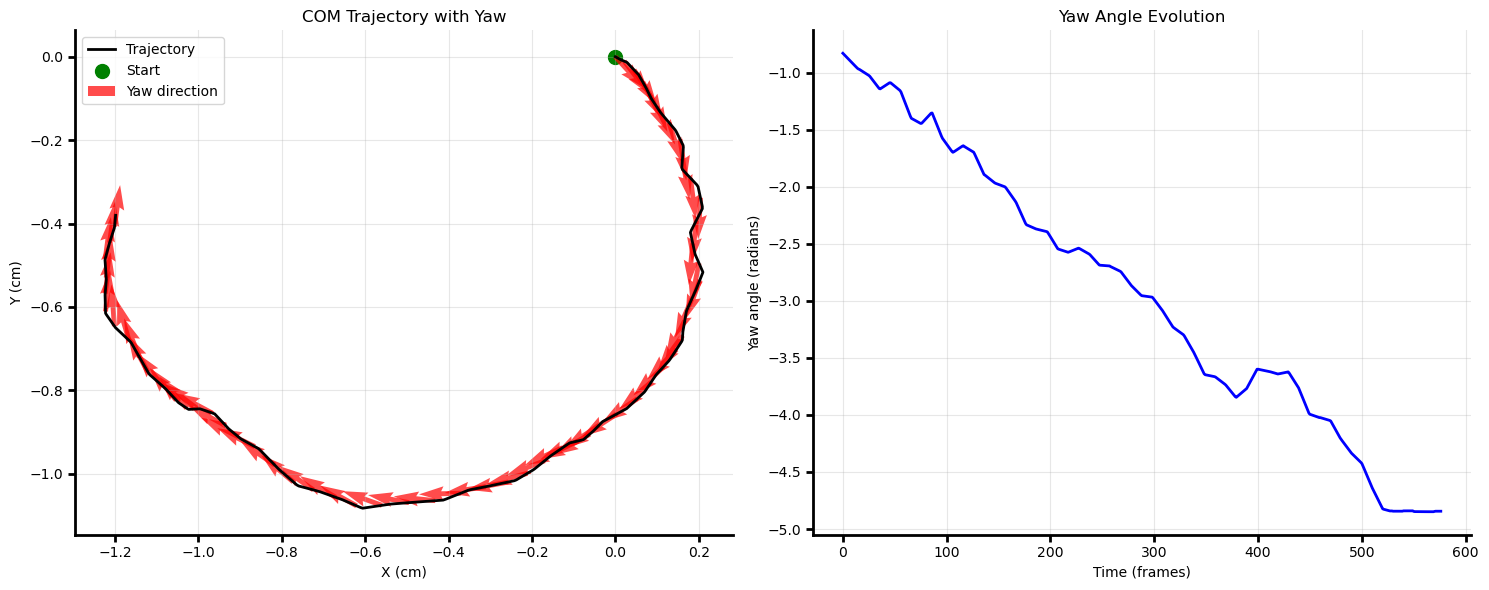

In [ ]:
clip_idx = 19
test_yaw, test_quat = calculate_yaw_and_quaternion(
    jnp.array(int_y_cm[clip_idx]),
    jnp.array(int_x_cm[clip_idx])
)

print(f"Yaw angles shape: {test_yaw.shape}")
print(f"Quaternions shape: {test_quat.shape}")
print(f"Sample yaw angles: {test_yaw[:5]}")
print(f"Sample quaternions: {test_quat[:5]}")

# Visualize the trajectory with calculated yaw
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot trajectory with yaw directions
x = int_x_cm[clip_idx]
y = int_y_cm[clip_idx]
u = jnp.cos(test_yaw)
v = jnp.sin(test_yaw)

ax1.plot(x, y, 'k-', linewidth=2, label='Trajectory')
ax1.scatter(x[0], y[0], c='g', s=100, label='Start')
ax1.quiver(x[::10], y[::10], u[::10], v[::10],
            angles='xy', scale_units='xy', scale=10,
            color='r', alpha=0.7, label='Yaw direction')
ax1.set_xlabel('X (cm)')
ax1.set_ylabel('Y (cm)')
ax1.set_title('COM Trajectory with Yaw')
ax1.axis('equal')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot yaw angles over time
ax2.plot(test_yaw, 'b-', linewidth=2)
ax2.set_xlabel('Time (frames)')
ax2.set_ylabel('Yaw angle (radians)')
ax2.set_title('Yaw Angle Evolution')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:

clip_idx = 19
# render_path = Path('/home/eabe/Research/MyRepos/Fly_tracking/assets/fruitfly_v2/fruitfly_v2_fast_simple.xml')
# spec = mujoco.MjSpec.from_file(render_path.as_posix())
# mj_model = mujoco.MjSpec().from_file('/home/eabe/Research/MyRepos/Fly_tracking/assets/fruitfly_v1/fruitfly_v1.xml').compile()
# mj_model = env.mj_model
mj_data = mujoco.MjData(mj_model)
mujoco.mj_forward(mj_model,mj_data)
scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True

t = 0
frames=[]
# qposes_rollout =  reference_clips.extract_clip(clip_idx).qpos #mocap_qpos_reshaped[clip_idx].copy()
qposes_rollout =  mocap_qpos_reshaped[clip_idx].copy()
with mujoco.Renderer(mj_model, height=512, width=512) as renderer:
    for t in tqdm(range(qposes_rollout.shape[0])):
        mj_data.qpos = qposes_rollout[t]
        mujoco.mj_forward(mj_model, mj_data)
        renderer.update_scene(mj_data, camera='track1_fly', scene_option=scene_option)
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=30)

  0%|          | 0/577 [00:00<?, ?it/s]

In [ ]:
from preprocessing.mjx_preprocess import process_clip, save_reference_clip_to_h5, load_reference_clip_from_h5

In [ ]:
import jax.numpy as jnp
from scipy import interpolate
import numpy as np

def interpolate_clip_to_5000hz(clip_data, current_hz=300, target_hz=5000):
    """
    Interpolate a single clip from current_hz to target_hz using cubic spline interpolation.
    
    Args:
        clip_data: Array of shape (time, qpos_dims) at current_hz
        current_hz: Current sampling frequency
        target_hz: Target sampling frequency
        
    Returns:
        interpolated_data: Array at target_hz sampling frequency
    """
    if len(clip_data.shape) != 2:
        raise ValueError(f"Expected 2D array (time, qpos), got shape {clip_data.shape}")
    
    # Convert JAX array to numpy for scipy interpolation
    clip_np = np.array(clip_data)
    
    # Create time arrays
    original_time_steps = clip_np.shape[0]
    original_duration = original_time_steps / current_hz  # duration in seconds
    
    # Original time points
    t_original = np.linspace(0, original_duration, original_time_steps)
    
    # New time points at target frequency
    new_time_steps = int(original_duration * target_hz)
    t_new = np.linspace(0, original_duration, new_time_steps)
    
    # Interpolate each qpos dimension separately
    interpolated_data = np.zeros((new_time_steps, clip_np.shape[1]))
    
    for dim in range(clip_np.shape[1]):
        # Use cubic spline interpolation for smooth results
        spline = interpolate.CubicSpline(t_original, clip_np[:, dim])
        interpolated_data[:, dim] = spline(t_new)
    
    print(f"Interpolated from {original_time_steps} frames ({current_hz}Hz) to {new_time_steps} frames ({target_hz}Hz)")
    print(f"Duration: {original_duration:.3f} seconds")
    
    return jnp.array(interpolated_data)

def interpolate_all_clips_to_5000hz(clips_list, current_hz=300, target_hz=5000):
    """
    Interpolate all clips in the list from current_hz to target_hz.
    
    Args:
        clips_list: List of clips, each with shape (time, qpos_dims)
        current_hz: Current sampling frequency
        target_hz: Target sampling frequency
        
    Returns:
        List of interpolated clips
    """
    interpolated_clips = []
    
    print(f"Interpolating {len(clips_list)} clips from {current_hz}Hz to {target_hz}Hz...")
    
    for i, clip in enumerate(tqdm(clips_list)):
        interpolated_clip = interpolate_clip_to_5000hz(clip, current_hz, target_hz)
        interpolated_clips.append(interpolated_clip)
        
        if i == 0:  # Show details for first clip
            print(f"First clip interpolation details:")
            print(f"  Original shape: {clip.shape}")
            print(f"  Interpolated shape: {interpolated_clip.shape}")
            print(f"  Upsampling factor: {interpolated_clip.shape[0] / clip.shape[0]:.2f}x")
    
    return interpolated_clips

In [ ]:
mocap_qpos_interp = interpolate_all_clips_to_5000hz(mocap_qpos_reshaped, current_hz=300, target_hz=500)


Interpolating 1729 clips from 300Hz to 500Hz...


  0%|          | 0/1729 [00:00<?, ?it/s]

Interpolated from 157 frames (300Hz) to 261 frames (500Hz)
Duration: 0.523 seconds
First clip interpolation details:
  Original shape: (157, 88)
  Interpolated shape: (261, 88)
  Upsampling factor: 1.66x
Interpolated from 469 frames (300Hz) to 781 frames (500Hz)
Duration: 1.563 seconds
Interpolated from 493 frames (300Hz) to 821 frames (500Hz)
Duration: 1.643 seconds
Interpolated from 157 frames (300Hz) to 261 frames (500Hz)
Duration: 0.523 seconds
Interpolated from 193 frames (300Hz) to 321 frames (500Hz)
Duration: 0.643 seconds
Interpolated from 169 frames (300Hz) to 281 frames (500Hz)
Duration: 0.563 seconds
Interpolated from 241 frames (300Hz) to 401 frames (500Hz)
Duration: 0.803 seconds
Interpolated from 181 frames (300Hz) to 301 frames (500Hz)
Duration: 0.603 seconds
Interpolated from 169 frames (300Hz) to 281 frames (500Hz)
Duration: 0.563 seconds
Interpolated from 217 frames (300Hz) to 361 frames (500Hz)
Duration: 0.723 seconds
Interpolated from 457 frames (300Hz) to 761 frame

In [ ]:
clip_idx = 25
# render_path = Path('/home/eabe/Research/MyRepos/Fly_tracking/assets/fruitfly_v1/fruitfly_v1.xml')
# spec = mujoco.MjSpec.from_file(render_path.as_posix())
# mj_model = spec.compile()
# mj_model = env.mj_model
mj_data = mujoco.MjData(mj_model)
mujoco.mj_forward(mj_model,mj_data)
scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True

t = 0
frames=[]
qposes_rollout =  mocap_qpos_interp[clip_idx].copy()
with mujoco.Renderer(mj_model, height=512, width=512) as renderer:
    for t in tqdm(range(qposes_rollout.shape[0])):
        mj_data.qpos = qposes_rollout[t]
        mujoco.mj_forward(mj_model, mj_data)
        renderer.update_scene(mj_data, camera='track1_fly', scene_option=scene_option)
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=30)

  0%|          | 0/961 [00:00<?, ?it/s]

In [ ]:
clip_len_interp = jnp.array([len(mocap_qpos_interp[i]) for i in range(len(mocap_qpos_interp))])
keep_idxs = jnp.where(((jnp.array(clip_len_interp) > 400) & (jnp.array(clip_len_interp) < 1200)))[0]
max_clip_len_interp = 1001# jnp.max(clip_len_interp[keep_idxs])

In [ ]:
mocap_qpos_interp_pad = []
for clip_idx in tqdm(keep_idxs):
    mocap_qpos_interp_pad.append(jnp.pad(mocap_qpos_interp[clip_idx], ((0, max_clip_len_interp - len(mocap_qpos_interp[clip_idx])), (0,0)), mode='edge'))
mocap_qpos_interp_pad = jnp.stack(mocap_qpos_interp_pad)

  0%|          | 0/1034 [00:00<?, ?it/s]

In [ ]:
clip_length = mocap_qpos_interp_pad.shape[1]
# mocap_qpos_interp_pad[:,:,env._wing_joint_idxs] = jnp.array([1.5,0.814,-0.821,1.5,0.814,-0.821])

start_step = 0

# jit the process_clip function 
jit_process_clip = jax.jit(process_clip)


# Reshape_qposes to have the batch dimension and vmap the jitted function
all_clips_qpos_interp = jnp.reshape(mocap_qpos_interp_pad, (-1, clip_length, mocap_qpos_interp_pad.shape[-1]))
vmap_jit_process_clip = jax.vmap(jit_process_clip, in_axes=(0,None,None))


# mj_model = env.mj_model
# spec = mujoco.MjSpec().from_file('/home/eabe/Research/MyRepos/Fly_tracking/assets/fruitfly/fruitfly_force_fast.xml')
# mj_model = spec.compile()
mj_data = mujoco.MjData(mj_model)
mujoco.mj_forward(mj_model,mj_data)

# Initialize MuJoCo model and data structures & place into GPU
mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)

all_clips_interp = vmap_jit_process_clip(all_clips_qpos_interp, mjx_model, mjx_data)

In [ ]:
all_clips_interp.position.shape

In [ ]:
qpos_all = jnp.concatenate([all_clips_interp.position, all_clips_interp.quaternion, all_clips_interp.joints], axis=-1)
qvel_all = jnp.concatenate([all_clips_interp.velocity, all_clips_interp.angular_velocity, all_clips_interp.joints_velocity], axis=-1)
xpos_all = all_clips_interp.body_positions
xquat_all = all_clips_interp.body_quaternions
qpos_names = [joint.name.split('-')[0] for joint in spec.joints if 'free' not in joint.name]
clip_lengths = clip_len_interp[keep_idxs]

In [ ]:
full_clips = {
    'qpos': qpos_all,
    'qvel': qvel_all,
    'xpos': xpos_all,
    'xquat': xquat_all,
    'qpos_names': qpos_names,
    'clip_lengths': jnp.asarray(clip_lengths),
}
# ioh5.save('/data/users/eabe/biomech_model/Flybody/datasets/walk/clips/Fruitfly_V2b_walk_500hz_avg.h5', full_clips)
ioh5.save('/data2/users/eabe/fly_neuromech/data/datasets/Fruitfly_V2b_walk_500hz_avg.h5', full_clips)
# save_reference_clip_to_h5('/data/users/eabe/biomech_model/Flybody/datasets/walk/clips/FruitflyV1_walk_500hz.h5', clip_names='all_clips', reference_clip=all_clips_interp)

In [12]:
ref_clips = ReferenceClips.from_path('/data2/users/eabe/fly_neuromech/data/datasets/Fruitfly_V2b_walk_500hz_avg.h5')

In [ ]:
ref_clips.save_chunked('/data2/users/eabe/fly_neuromech/data/datasets/Fruitfly_V2b_walk_500hz_avg_chunked.h5')

Saving ReferenceClips with chunking strategy:
  qpos: (1034, 1001, 88) -> chunks=(1, 1001, 88)
  qvel: (1034, 1001, 87) -> chunks=(1, 1001, 87)
  xpos: (1034, 1001, 74, 3) -> chunks=(1, 1001, 74, 3)
  xquat: (1034, 1001, 74, 4) -> chunks=(1, 1001, 74, 4)
Saved to /data2/users/eabe/fly_neuromech/data/datasets/Fruitfly_V2b_walk_500hz_avg_chunked.h5 with optimal chunking for parallel single-clip access


In [9]:
from mujoco_playground._src.mjx_env import get_qpos_ids

In [10]:
import mujoco as mj

def filter_model_to_t1_only(xml_path):
    """
    Remove all joints, actuators, and tendons that don't contain 'T1' in their name
    using spec.delete() API.
    
    Args:
        xml_path: Path to the MuJoCo XML file
        
    Returns:
        Compiled MjModel with only T1 joints, actuators, and tendons
    """
    # Load spec
    spec = mj.MjSpec.from_file(xml_path)
    
    # Collect all joints to delete (need to collect first, then delete)
    joints_to_delete = []
    for body in spec.bodies:
        for joint in body.joints:
            if ('T1' not in joint.name) & ('wing' not in joint.name):
                joints_to_delete.append(joint)
    
    # Collect all actuators to delete
    actuators_to_delete = []
    for actuator in spec.actuators:
        if ('T1' not in actuator.name) & ('wing' not in actuator.name):
            actuators_to_delete.append(actuator)
    
    # Collect all tendons to delete
    tendons_to_delete = []
    for tendon in spec.tendons:
        if 'T1' not in tendon.name:
            tendons_to_delete.append(tendon)
    
    # Collect all tendons to delete
    sensors_to_delete = []
    for sensor in spec.sensors:
        if 'T1' not in sensor.name:
            sensors_to_delete.append(sensor)
            
    print(f"Joints: {len(spec.bodies)} bodies, removing {len(joints_to_delete)} joints without 'T1'")
    print(f"Actuators: {len(list(spec.actuators))} total, removing {len(actuators_to_delete)} without 'T1'")
    print(f"Tendons: {len(list(spec.tendons))} total, removing {len(tendons_to_delete)} without 'T1'")
    print(f"Sensors: {len(list(spec.sensors))} total, removing {len(sensors_to_delete)} without 'T1'")
    
    # Delete joints
    for joint in joints_to_delete:
        spec.delete(joint)
    
    # Delete actuators
    for actuator in actuators_to_delete:
        spec.delete(actuator)
    
    # Delete tendons
    for tendon in tendons_to_delete:
        spec.delete(tendon)
    
    # Delete sensors
    for sensor in sensors_to_delete:
        spec.delete(sensor)
    
    # Compile to model
    model = spec.compile()
    
    print(f"\nFiltered model: {model.njnt} joints, {model.nu} actuators, {model.ntendon} tendons")
    
    return model, spec

# Example usage:
xml_path = '../../fruitfly_body_models/fruitfly_v2.1/fruitfly_v2.1_muscles.xml'
t1_model, t1_spec = filter_model_to_t1_only(xml_path)

Joints: 74 bodies, removing 54 joints without 'T1'
Actuators: 197 total, removing 139 without 'T1'
Tendons: 190 total, removing 138 without 'T1'
Sensors: 63 total, removing 39 without 'T1'

Filtered model: 28 joints, 58 actuators, 52 tendons


In [18]:
wing_joint_idxs = tuple(get_qpos_ids(t1_model,[idx for idx, joint in enumerate(t1_spec.joints) if 'wing' in joint.name]).tolist())

default_wing_pos = jnp.array([1.5, 0.814, -0.821, 1.5, 0.814, -0.821])


In [19]:
T1_jnt_idxs = get_qpos_ids(mj_model,[joint.id for joint in spec.joints if ('T1' in joint.name) | ('wing' in joint.name)])
T1_jnt_idxs

array([10, 11, 12, 13, 14, 15, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])

In [20]:
qposes_T1 = ref_clips.qpos[:,:,T1_jnt_idxs]
qposes_T1 = qposes_T1.at[:,:,wing_joint_idxs].set(default_wing_pos)
qvels_T1 = ref_clips.qvel[:,:,T1_jnt_idxs-1]
xpos_all = ref_clips.xpos
xquat_all = ref_clips.xquat
qpos_names_T1 = [name for name in ref_clips.qpos_names if 'T1' in name]
clip_lengths = ref_clips.clip_lengths
full_clips = {
    'qpos': qposes_T1,
    'qvel': qvels_T1,
    'xpos': xpos_all,
    'xquat': xquat_all,
    'qpos_names': qpos_names_T1,
    'clip_lengths': jnp.asarray(clip_lengths),
}
ioh5.save('/data2/users/eabe/fly_neuromech/data/datasets/Fruitfly_V2b_walk_500hz_avg_T1only.h5', full_clips)


In [21]:
clip_idx = 25
# render_path = Path('/home/eabe/Research/MyRepos/Fly_tracking/assets/fruitfly_v1/fruitfly_v1.xml')
# spec = mujoco.MjSpec.from_file(render_path.as_posix())
# mj_model = spec.compile()
# mj_model = env.mj_model
mj_data = mujoco.MjData(t1_model)
mujoco.mj_forward(t1_model,mj_data)
scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True

t = 0
frames=[]
qposes_rollout =  qposes_T1[clip_idx].copy()
with mujoco.Renderer(t1_model, height=512, width=512) as renderer:
    for t in tqdm(range(qposes_rollout.shape[0])):
        mj_data.qpos = qposes_rollout[t]
        mujoco.mj_forward(t1_model, mj_data)
        renderer.update_scene(mj_data, camera='track1', scene_option=scene_option)
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=30)

  0%|          | 0/1001 [00:00<?, ?it/s]

In [ ]:
ref_clips.print_info()

In [ ]:
flight_dict = reference_clips.to_dict()

In [ ]:
combined_data = {}
for key in flight_dict.keys():
    if key != 'qpos_names':
        combined_data[key] = jnp.concatenate([full_clips[key], flight_dict[key]], axis=0)
combined_data['qpos_names'] = flight_dict['qpos_names']

In [ ]:
ioh5.save('/data/users/eabe/biomech_model/Flybody/datasets/unified/clips/FruitflyV2_unified.h5', combined_data)

In [ ]:
combined_clips = ReferenceClips.from_dict(combined_data)
combined_clips.print_info()

# Procustes Alignment

In [ ]:
env = imitation.Imitation(cfg, reference_clips=reference_clips)
mj_model = env.mj_model
data = mujoco.MjData(mj_model)
site_names = [site.name for site in env._spec.sites if 'tracking' in site.name]
site_idxs = jnp.array([site.id for site in env._spec.sites if 'tracking' in site.name])

In [ ]:

mj_data = mujoco.MjData(mj_model)

mujoco.mj_forward(mj_model, mj_data)
ref_pose = mj_data.site_xpos[site_idxs]
print('Aligning to zero at ref_pose:', ref_pose[0], site_names[0])
ref_pose = ref_pose - ref_pose[0]


    
fly_clrs = [
    [[0.22, 0.46, 0.67]],
    [[0.76, 0.21, 0.17]],
    [[0.92, 0.5, 0.18]],
    [[0.55, 0.41, 0.72]],
    [[0.32, 0.62, 0.24]],
    [[0.51, 0.34, 0.30]],
]

clrs_tr = [
    '#ff4081ff',
    '#1e90ffff',
    '#8b4513ff',
    '#ff4081ff'
    ]

end_eff_indices = jnp.array([4, 9, 14, 19, 24, 29])


In [ ]:
def visualize_alignment(original_points, aligned_points, reference_pose, frame_idx=0,
                        title="Procrustes Alignment Verification",
                        end_eff_indices=None, floor_height=-0.125, contact_threshold=0.001):
    """
    Enhanced visualization of Procrustes alignment results with ground plane and contact points

    Args:
        original_points: (T, N, 3) or (N, 3) original keypoints
        aligned_points: (T, N, 3) or (N, 3) aligned keypoints
        reference_pose: (N, 3) reference pose
        frame_idx: Frame index to visualize if input is temporal
        title: Plot title
        end_eff_indices: Indices of end effectors for contact detection
        floor_height: Height of the floor/ground plane
        contact_threshold: Distance threshold for contact detection
    """
    # Default end effector indices if not provided
    if end_eff_indices is None:
        end_eff_indices = np.array([4, 9, 14, 19, 24, 29])

    # Define fly skeleton connections
    fly_skel = np.array([(n,n+1) for n in range(29)])
    fly_skel = np.stack((fly_skel[:4],fly_skel[5:9],fly_skel[10:14],fly_skel[15:19],fly_skel[20:24],fly_skel[25:30],))

    # Use the provided fly colors for each leg
    fly_clrs = [
        [0.22, 0.46, 0.67],
        [0.76, 0.21, 0.17],
        [0.92, 0.5, 0.18],
        [0.55, 0.41, 0.72],
        [0.32, 0.62, 0.24],
        [0.51, 0.34, 0.30],
    ]

    def draw_ground_plane(ax, points, floor_height, alpha=0.2):
        """Draw ground plane based on the extent of the points"""
        x_min, x_max = points[:, 0].min(), points[:, 0].max()
        y_min, y_max = points[:, 1].min(), points[:, 1].max()

        # Expand the plane slightly beyond the points
        margin = 0.02
        x_range = x_max - x_min
        y_range = y_max - y_min
        x_min -= x_range * margin
        x_max += x_range * margin
        y_min -= y_range * margin
        y_max += y_range * margin

        # Create ground plane mesh
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 10),
                           np.linspace(y_min, y_max, 10))
        zz = np.full_like(xx, floor_height)

        ax.plot_surface(xx, yy, zz, color='gray', alpha=alpha)

    def draw_skeleton_with_contacts(ax, points, point_color, skeleton_alpha=0.6,
                                  show_contacts=False, floor_height=None, contact_threshold=None):
        """Draw skeleton connections and highlight contact points"""
        # Draw points
        ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                  c=point_color, s=50, alpha=0.8)

        # Draw skeleton connections for each leg
        for leg_idx, leg_connections in enumerate(fly_skel):
            color = fly_clrs[leg_idx % len(fly_clrs)]
            for connection in leg_connections:
                if connection[1] < len(points):
                    start_point = points[connection[0]]
                    end_point = points[connection[1]]
                    ax.plot([start_point[0], end_point[0]],
                           [start_point[1], end_point[1]],
                           [start_point[2], end_point[2]],
                           color=color, alpha=skeleton_alpha, linewidth=2)

        # Highlight contact points if requested
        if show_contacts and floor_height is not None and contact_threshold is not None:
            contact_points = []
            for idx in end_eff_indices:
                if idx < len(points):
                    end_eff_z = points[idx, 2]
                    if abs(end_eff_z - floor_height) <= contact_threshold:
                        contact_points.append(points[idx])

            if contact_points:
                contact_points = np.array(contact_points)
                ax.scatter(contact_points[:, 0], contact_points[:, 1], contact_points[:, 2],
                         c='red', s=100, alpha=1.0, marker='*', edgecolors='black')

            return len(contact_points)
        return 0

    # Handle both single frame and temporal data
    if original_points.ndim == 3:
        orig_frame = original_points[frame_idx]
        aligned_frame = aligned_points[frame_idx]
    else:
        orig_frame = original_points
        aligned_frame = aligned_points

    # Calculate contact information for aligned points
    aligned_end_effs = aligned_frame[end_eff_indices]
    contact_mask = np.abs(aligned_end_effs[:, 2] - floor_height) <= contact_threshold
    n_contacts = np.sum(contact_mask)

    fig = plt.figure(figsize=(24, 8))

    # Plot 1: Original vs Reference
    ax1 = fig.add_subplot(141, projection='3d')
    draw_skeleton_with_contacts(ax1, orig_frame, 'red')
    draw_skeleton_with_contacts(ax1, reference_pose, 'blue')
    ax1.set_title('Original vs Reference')
    ax1.scatter([], [], [], c='red', s=50, label='Original')
    ax1.scatter([], [], [], c='blue', s=50, label='Reference')
    ax1.legend()
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    # Plot 2: Aligned vs Reference with ground plane
    ax2 = fig.add_subplot(142, projection='3d')
    draw_ground_plane(ax2, aligned_frame, floor_height)
    n_contacts_aligned = draw_skeleton_with_contacts(ax2, aligned_frame, 'green',
                                                   show_contacts=True, floor_height=floor_height,
                                                   contact_threshold=contact_threshold)
    draw_skeleton_with_contacts(ax2, reference_pose, 'blue')
    ax2.set_title(f'Aligned vs Reference\nContacts: {n_contacts_aligned}/{len(end_eff_indices)}')
    ax2.scatter([], [], [], c='green', s=50, label='Aligned')
    ax2.scatter([], [], [], c='blue', s=50, label='Reference')
    ax2.scatter([], [], [], c='red', s=100, marker='*', label='Contacts')
    ax2.legend()
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    # Plot 3: All together with ground plane
    ax3 = fig.add_subplot(143, projection='3d')
    draw_ground_plane(ax3, aligned_frame, floor_height)
    draw_skeleton_with_contacts(ax3, orig_frame, 'red', skeleton_alpha=0.4)
    draw_skeleton_with_contacts(ax3, aligned_frame, 'green', skeleton_alpha=0.7,
                              show_contacts=True, floor_height=floor_height,
                              contact_threshold=contact_threshold)
    draw_skeleton_with_contacts(ax3, reference_pose, 'blue', skeleton_alpha=0.9)
    ax3.set_title(f'All Together\nContacts: {n_contacts}/{len(end_eff_indices)}')
    ax3.scatter([], [], [], c='red', s=30, label='Original')
    ax3.scatter([], [], [], c='green', s=30, label='Aligned')
    ax3.scatter([], [], [], c='blue', s=50, label='Reference')
    ax3.scatter([], [], [], c='red', s=100, marker='*', label='Contacts')
    ax3.legend()
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')

    # Plot 4: End effector heights comparison
    ax4 = fig.add_subplot(144)

    # Original end effector heights
    orig_end_eff_heights = orig_frame[end_eff_indices, 2]
    aligned_end_eff_heights = aligned_frame[end_eff_indices, 2]
    ref_end_eff_heights = reference_pose[end_eff_indices, 2]

    x_pos = np.arange(len(end_eff_indices))
    width = 0.25

    bars1 = ax4.bar(x_pos - width, orig_end_eff_heights, width, label='Original', color='red', alpha=0.7)
    bars2 = ax4.bar(x_pos, aligned_end_eff_heights, width, label='Aligned', color='green', alpha=0.7)
    bars3 = ax4.bar(x_pos + width, ref_end_eff_heights, width, label='Reference', color='blue', alpha=0.7)

    # Mark contacts
    for i, (idx, is_contact) in enumerate(zip(end_eff_indices, contact_mask)):
        if is_contact:
            ax4.scatter(i, aligned_end_eff_heights[i], color='red', s=100, marker='*', zorder=10)

    ax4.axhline(y=floor_height, color='gray', linestyle='--', alpha=0.8, label=f'Floor ({floor_height})')
    ax4.axhline(y=floor_height + contact_threshold, color='orange', linestyle=':', alpha=0.6,
                label=f'Contact threshold')
    ax4.axhline(y=floor_height - contact_threshold, color='orange', linestyle=':', alpha=0.6)

    ax4.set_xlabel('End Effector Index')
    ax4.set_ylabel('Height (Z)')
    ax4.set_title(f'End Effector Heights\nContacts: {n_contacts}/{len(end_eff_indices)}')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels([f'E{idx}' for idx in end_eff_indices])
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.suptitle(f"{title} - Frame {frame_idx}", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Print contact summary
    print(f"\nContact Summary for Frame {frame_idx}:")
    print(f"  Total contacts: {n_contacts}/{len(end_eff_indices)}")
    print(f"  Floor height: {floor_height}")
    print(f"  Contact threshold: {contact_threshold}")
    for i, (idx, height, is_contact) in enumerate(zip(end_eff_indices, aligned_end_eff_heights, contact_mask)):
        status = "✓ CONTACT" if is_contact else "  above"
        print(f"  End effector {idx}: {height:.4f} {status}")

In [ ]:
from optimized_floor_alignment import *

In [ ]:

# Visualize alignment for first few frames
test_clip_idx = 25
kp_test_clip = bout_dict[f'walking_bout{test_clip_idx:04}']['orig_kp']
ref_pose_jax = jnp.array(ref_pose)
aligned_test_clip, procrustes_info = jit_vectorized_procrustes_with_scaling(kp_test_clip, ref_pose_jax, use_clip_average=True)
frames_to_show = [0, 10, 25] if kp_test_clip.shape[0] > 25 else [0]

for frame_idx in frames_to_show:
    if frame_idx < kp_test_clip.shape[0]:
        visualize_alignment(
            kp_test_clip, 
            aligned_test_clip, 
            ref_pose_jax, 
            frame_idx=frame_idx,
            title=f"Clip {test_clip_idx} Alignment"
        )


In [ ]:
end_eff_indices = jnp.array([4, 9, 14, 19, 24, 29])

endeff_xpos = aligned_test_clip[:,end_eff_indices]
percentile = 10
z_threshold = jnp.percentile(endeff_xpos[...,2], percentile,axis=0)
z_threshold
xpos_percent = jnp.stack([endeff_xpos[endeff_xpos[:,n,2] <= z_threshold[n],n,:] for n in range(endeff_xpos.shape[1])])
ground_points = xpos_percent.reshape(-1,3)

In [ ]:
for n in range(xpos_percent.shape[0]):
    plt.plot(xpos_percent[n,:,2], alpha=0.3)

In [ ]:
plt.plot(endeff_xpos[...,2])
plt.axhline(z_threshold[0], color='r')
plt.axhline(z_threshold[1], color='g')
plt.axhline(z_threshold[2], color='b')
plt.axhline(z_threshold[3], color='c')
plt.axhline(z_threshold[4], color='m')
plt.axhline(z_threshold[5], color='y')
plt.axhline(-0.125, color='k')  

In [ ]:
plt.scatter(xpos_percent[...,0],xpos_percent[...,1],c=xpos_percent[...,2])

In [ ]:

def visualize_ground_contact_alignment(original_points, rotated_points, translated_points, final_points, 
                                     alignment_info, frame_idx=0):
    """
    Visualize the three-step ground contact alignment process: rotation → translation → clipping
    
    Args:
        original_points: Original keypoint trajectories (after Procrustes)
        rotated_points: After step 1 (rotation only)
        translated_points: After step 2a (rotation + translation, before clipping)
        final_points: After step 2b (rotation + translation + clipping)
        alignment_info: Information from align_to_ground_plane_with_contact
        frame_idx: Frame index to visualize
    """
    fig = plt.figure(figsize=(24, 16))
    
    # Get frame data
    if original_points.ndim == 3:
        orig_frame = original_points[frame_idx]
        rotated_frame = rotated_points[frame_idx] 
        translated_frame = translated_points[frame_idx]
        final_frame = final_points[frame_idx]
    else:
        orig_frame = original_points
        rotated_frame = rotated_points
        translated_frame = translated_points
        final_frame = final_points
    
    # Extract info
    ground_points = alignment_info['ground_points']
    ground_normal = alignment_info['ground_normal']
    target_z = alignment_info['target_z']
    end_eff_indices = jnp.array([4, 9, 14, 19, 24, 29])
    
    def create_plane_mesh(center, normal, extent=0.08, grid_size=10):
        """Create a mesh for visualizing a plane"""
        if abs(normal[2]) < 0.9:
            v1 = jnp.cross(normal, jnp.array([0, 0, 1]))
        else:
            v1 = jnp.cross(normal, jnp.array([1, 0, 0]))
        v1 = v1 / jnp.linalg.norm(v1)
        v2 = jnp.cross(normal, v1)
        v2 = v2 / jnp.linalg.norm(v2)
        
        u = jnp.linspace(-extent, extent, grid_size)
        v = jnp.linspace(-extent, extent, grid_size)
        uu, vv = jnp.meshgrid(u, v)
        
        plane_points = (center[:, None, None] + 
                       uu[None, :, :] * v1[:, None, None] + 
                       vv[None, :, :] * v2[:, None, None])
        
        return plane_points[0], plane_points[1], plane_points[2]
    
    # Top row: Step-by-step process
    # Plot 1: Original with fitted ground plane
    ax1 = fig.add_subplot(241, projection='3d')
    ax1.scatter(orig_frame[:, 0], orig_frame[:, 1], orig_frame[:, 2], 
               c='blue', alpha=0.5, s=15, label='Keypoints')
    ax1.scatter(ground_points[:, 0], ground_points[:, 1], ground_points[:, 2], 
               c='red', s=50, alpha=0.9, label='Ground points')
    
    # Highlight end effectors
    orig_end_effs = orig_frame[end_eff_indices]
    ax1.scatter(orig_end_effs[:, 0], orig_end_effs[:, 1], orig_end_effs[:, 2], 
               c='orange', s=80, alpha=0.8, marker='s', label='End effectors')
    
    ax1.set_title(f'Step 0: Original\\n{alignment_info["n_ground_points"]} ground points')
    ax1.legend()
    ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
    
    # Plot 2: After rotation (step 1)
    ax2 = fig.add_subplot(242, projection='3d')
    ax2.scatter(rotated_frame[:, 0], rotated_frame[:, 1], rotated_frame[:, 2], 
               c='green', alpha=0.5, s=15, label='Rotated keypoints')
    
    rotated_end_effs = rotated_frame[end_eff_indices]
    ax2.scatter(rotated_end_effs[:, 0], rotated_end_effs[:, 1], rotated_end_effs[:, 2], 
               c='lime', s=80, alpha=0.8, marker='s', label='Rotated end effectors')
    
    # Show the min end effector height
    min_z = jnp.min(rotated_end_effs[:, 2])
    ax2.axhline(y=min_z, color='red', linestyle='--', alpha=0.7)
    
    ax2.set_title(f'Step 1: After Rotation\\nLowest end effector: Z={min_z:.3f}')
    ax2.legend()
    ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')
    
    # Plot 3: After translation (step 2a) - before clipping
    ax3 = fig.add_subplot(243, projection='3d')
    ax3.scatter(translated_frame[:, 0], translated_frame[:, 1], translated_frame[:, 2], 
               c='cyan', alpha=0.5, s=15, label='Translated keypoints')
    
    translated_end_effs = translated_frame[end_eff_indices]
    below_floor = translated_end_effs[:, 2] < target_z
    
    # Color end effectors based on whether they're below floor
    if jnp.any(below_floor):
        ax3.scatter(translated_end_effs[~below_floor, 0], translated_end_effs[~below_floor, 1], 
                   translated_end_effs[~below_floor, 2], 
                   c='cyan', s=80, alpha=0.8, marker='s', label='Above/at floor')
        ax3.scatter(translated_end_effs[below_floor, 0], translated_end_effs[below_floor, 1], 
                   translated_end_effs[below_floor, 2], 
                   c='red', s=80, alpha=0.8, marker='v', label='Below floor')
    else:
        ax3.scatter(translated_end_effs[:, 0], translated_end_effs[:, 1], translated_end_effs[:, 2], 
                   c='cyan', s=80, alpha=0.8, marker='s', label='End effectors')
    
    # Draw floor plane
    x_range = [translated_frame[:, 0].min(), translated_frame[:, 0].max()]
    y_range = [translated_frame[:, 1].min(), translated_frame[:, 1].max()]
    xx, yy = jnp.meshgrid(jnp.linspace(x_range[0], x_range[1], 10),
                         jnp.linspace(y_range[0], y_range[1], 10))
    zz = jnp.full_like(xx, target_z)
    ax3.plot_surface(xx, yy, zz, alpha=0.2, color='gray')
    
    ax3.set_title(f'Step 2a: After Translation\\nLowest at Z={target_z}, {jnp.sum(below_floor)} below floor')
    ax3.legend()
    ax3.set_xlabel('X'); ax3.set_ylabel('Y'); ax3.set_zlabel('Z')
    
    # Plot 4: Final result after clipping (step 2b)
    ax4 = fig.add_subplot(244, projection='3d')
    ax4.scatter(final_frame[:, 0], final_frame[:, 1], final_frame[:, 2], 
               c='purple', alpha=0.5, s=15, label='Final keypoints')
    
    final_end_effs = final_frame[end_eff_indices]
    at_floor = jnp.abs(final_end_effs[:, 2] - target_z) < 1e-6
    above_floor = final_end_effs[:, 2] > target_z + 1e-6
    
    if jnp.any(at_floor):
        ax4.scatter(final_end_effs[at_floor, 0], final_end_effs[at_floor, 1], 
                   final_end_effs[at_floor, 2], 
                   c='red', s=100, alpha=1.0, marker='*', label='Ground contact', edgecolors='black')
    if jnp.any(above_floor):
        ax4.scatter(final_end_effs[above_floor, 0], final_end_effs[above_floor, 1], 
                   final_end_effs[above_floor, 2], 
                   c='orange', s=80, alpha=0.8, marker='o', label='Above ground')
    
    # Draw floor plane
    ax4.plot_surface(xx, yy, zz, alpha=0.2, color='gray')
    
    ax4.set_title(f'Step 2b: Final (Clipped)\\n{jnp.sum(at_floor)} contacts, {jnp.sum(above_floor)} above')
    ax4.legend()
    ax4.set_xlabel('X'); ax4.set_ylabel('Y'); ax4.set_zlabel('Z')
    
    # Bottom row: Analysis plots
    # Plot 5: End effector heights through all steps
    ax5 = fig.add_subplot(245)
    
    orig_heights = orig_frame[end_eff_indices, 2]
    rotated_heights = rotated_frame[end_eff_indices, 2]
    translated_heights = translated_frame[end_eff_indices, 2]
    final_heights = final_frame[end_eff_indices, 2]
    
    x_pos = jnp.arange(len(end_eff_indices))
    width = 0.2
    
    ax5.bar(x_pos - 1.5*width, orig_heights, width, label='Original', alpha=0.7, color='blue')
    ax5.bar(x_pos - 0.5*width, rotated_heights, width, label='Rotated', alpha=0.7, color='green') 
    ax5.bar(x_pos + 0.5*width, translated_heights, width, label='Translated', alpha=0.7, color='cyan')
    ax5.bar(x_pos + 1.5*width, final_heights, width, label='Final', alpha=0.7, color='purple')
    
    ax5.axhline(y=target_z, color='gray', linestyle='--', linewidth=2, label=f'Target ({target_z})')
    
    ax5.set_xlabel('End Effector Index')
    ax5.set_ylabel('Height (Z)')
    ax5.set_title('End Effector Heights - All Steps')
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels([f'E{idx}' for idx in end_eff_indices])
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Contact analysis over trajectory
    ax6 = fig.add_subplot(246)
    
    # Analyze contacts over time (all frames)
    all_final_end_effs = final_points[:, end_eff_indices, 2]  # (T, n_endeff)
    contacts_per_frame = jnp.sum(jnp.abs(all_final_end_effs - target_z) < 1e-6, axis=1)  # (T,)
    
    ax6.plot(contacts_per_frame, 'purple', linewidth=2, label='Contacts per frame')
    ax6.axhline(y=len(end_eff_indices), color='red', linestyle='--', alpha=0.7, label='All 6 feet')
    ax6.fill_between(range(len(contacts_per_frame)), contacts_per_frame, alpha=0.3, color='purple')
    
    ax6.set_xlabel('Frame')
    ax6.set_ylabel('Number of End Effectors in Contact')
    ax6.set_title('Ground Contacts Over Time')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    ax6.set_ylim(0, len(end_eff_indices) + 0.5)
    
    # Plot 7: Alignment statistics
    ax7 = fig.add_subplot(247)
    
    # Calculate stats
    mean_contacts = jnp.mean(contacts_per_frame)
    contact_ratio = alignment_info['contact_ratio']
    n_clipped = alignment_info['n_clipped']
    
    stats_text = f"""Ground Contact Alignment Results:

Rotation:
• Plane normal: [{ground_normal[0]:.3f}, {ground_normal[1]:.3f}, {ground_normal[2]:.3f}]
• Rotation angle: {jnp.degrees(jnp.arccos(jnp.clip(jnp.dot(ground_normal, jnp.array([0., 0., 1.])), -1, 1))):.2f}°

Translation & Clipping:
• Vertical translation: {alignment_info['translation'][2]:.4f}
• Points clipped to floor: {n_clipped}
• Mean contacts per frame: {mean_contacts:.2f}/{len(end_eff_indices)}
• Overall contact ratio: {contact_ratio:.1%}

Ground Point Selection:
• Percentile threshold: {alignment_info['percentile']}%
• Ground points found: {alignment_info['n_ground_points']}
"""
    
    ax7.text(0.1, 0.9, stats_text, fontsize=11, transform=ax7.transAxes, verticalalignment='top')
    ax7.set_xlim(0, 1)
    ax7.set_ylim(0, 1)
    ax7.axis('off')
    ax7.set_title('Alignment Statistics')
    
    # Plot 8: Height distribution comparison
    ax8 = fig.add_subplot(248)
    
    ax8.hist(orig_heights, bins=15, alpha=0.5, label='Original', color='blue', density=True)
    ax8.hist(final_heights, bins=15, alpha=0.7, label='Final', color='purple', density=True)
    ax8.axvline(x=target_z, color='gray', linestyle='--', linewidth=2, label=f'Target ({target_z})')
    
    ax8.set_xlabel('Height (Z)')
    ax8.set_ylabel('Density')
    ax8.set_title('End Effector Height Distribution')
    ax8.legend()
    ax8.grid(True, alpha=0.3)
    
    plt.suptitle(f'Ground Contact Alignment - Frame {frame_idx}', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print detailed summary
    print(f"\\nGround Contact Alignment Summary:")
    print(f"  Ground points: {alignment_info['n_ground_points']} (percentile {alignment_info['percentile']}%)")
    print(f"  \\n  Step 1 - Rotation:")
    print(f"    Rotation angle: {jnp.degrees(jnp.arccos(jnp.clip(jnp.dot(ground_normal, jnp.array([0., 0., 1.])), -1, 1))):.2f}°")
    print(f"  \\n  Step 2 - Translation & Clipping:")
    print(f"    Vertical translation: {alignment_info['translation'][2]:.4f}")
    print(f"    Points clipped to floor: {n_clipped}")
    print(f"    Final contacts: {jnp.sum(jnp.abs(final_frame[end_eff_indices, 2] - target_z) < 1e-6)}/{len(end_eff_indices)}")
    print(f"    Mean contacts per frame: {mean_contacts:.2f}")
    print(f"    Contact ratio: {contact_ratio:.1%}")

In [ ]:
# Example usage of ground contact alignment (ensures all end effectors touch ground)
test_clip_idx = 100
kp_test_clip = bout_dict[f'walking_bout{test_clip_idx:04}']['orig_kp']
ref_pose_jax = jnp.array(ref_pose)

# First apply Procrustes alignment
aligned_test_clip, procrustes_info = jit_vectorized_procrustes_with_scaling(kp_test_clip, ref_pose_jax)

ground_contact_clip, contact_info = align_to_ground_plane_with_contact(
    aligned_test_clip, end_eff_indices, percentile,target_z=-0.125
)

# Generate intermediate steps for visualization
rotation_matrix = contact_info['rotation_matrix']
rotated_clip = jnp.einsum('ij,tnj->tni', rotation_matrix, aligned_test_clip)
translation = contact_info['translation']
translated_clip = rotated_clip + translation

print(f"Applied ground contact alignment to clip {test_clip_idx}")
print(f"Ground points found: {contact_info['n_ground_points']}")
print(f"Points clipped to floor: {contact_info['n_clipped']}")
print(f"Contact ratio: {contact_info['contact_ratio']:.1%}")
print(f"Mean contacts per frame: {contact_info['n_contacts'] / (ground_contact_clip.shape[0] * len(contact_info['z_thresholds'])):.2f}/6")

# Visualize the complete process
visualize_ground_contact_alignment(
    aligned_test_clip, rotated_clip, translated_clip, ground_contact_clip, 
    contact_info, frame_idx=112
)

In [ ]:
plt.plot(ground_contact_clip[:,end_eff_indices[2:4],2])

In [ ]:
# Test the updated ground contact alignment pipeline (fixed for JIT compatibility)
# Import the updated functions
import importlib
import optimized_floor_alignment
importlib.reload(optimized_floor_alignment)

from optimized_floor_alignment import (
    complete_alignment_pipeline_with_ground_contact,
    batch_process_with_ground_contact
)

# Test on a single clip first
test_clip_idx = 35
floor_height = -0.125

kp_test_clip = bout_dict[f'walking_bout{test_clip_idx:04}']['orig_kp']
ref_pose_jax = jnp.array(ref_pose)
end_eff_indices = jnp.array([4, 9, 14, 19, 24, 29])

print(f"Testing updated ground contact alignment on clip {test_clip_idx}")
print(f"Original clip shape: {kp_test_clip.shape}")

# Apply the complete pipeline (now with pre-computed ground plane parameters)
start_time = time.time()
aligned_clip, pipeline_info = complete_alignment_pipeline_with_ground_contact(
    jnp.array(kp_test_clip),
    ref_pose_jax,
    end_eff_indices,
    percentile=5.0,
    target_z=floor_height
)
processing_time = time.time() - start_time

print(f"\\nProcessing completed in {processing_time:.4f} seconds")
print(f"Aligned clip shape: {aligned_clip.shape}")
print(f"\\nPipeline Results:")
print(f"  Procrustes mean error: {pipeline_info['procrustes']['mean_error']:.6f}")
# print(f"  Ground contact mean contacts: {pipeline_info['ground_contact']['mean_contacts']:.2f}/6")
# print(f"  Total contacts: {pipeline_info['ground_contact']['total_contacts']}")
# print(f"  Total clipped points: {pipeline_info['ground_contact']['total_clipped']}")
# print(f"  Ground points found: {pipeline_info['ground_contact']['n_ground_points']}")

print(f"\\n✅ Updated pipeline working correctly with pre-computed ground plane parameters!")

In [ ]:

# Visualize alignment for first few frames
test_clip_idx = 2
kp_test_clip = bout_dict[f'walking_bout{test_clip_idx:04}']['orig_kp']
ref_pose_jax = jnp.array(ref_pose)
# aligned_test_clip, procrustes_info = jit_vectorized_procrustes_with_scaling(kp_test_clip, ref_pose_jax)
frames_to_show = [0, 10, 25, 123, 342, -1] if kp_test_clip.shape[0] > 25 else [0]

for frame_idx in frames_to_show:
    if frame_idx < kp_test_clip.shape[0]:
        visualize_alignment(
            kp_test_clip, 
            aligned_clip, 
            ref_pose_jax, 
            frame_idx=frame_idx,
            title=f"Clip {test_clip_idx} Alignment"
        )

In [ ]:

plt.plot(aligned_clip[:,end_eff_indices[2:4],2])   

In [ ]:
floor_height = -0.125

kp_test_clip = bout_dict[f'walking_bout{test_clip_idx:04}']['orig_kp']

ref_pose_jax = jnp.array(ref_pose)
end_eff_indices = jnp.array([4, 9, 14, 19, 24, 29])
for clip in tqdm(bout_dict.keys()):
    kp_clip = bout_dict[clip]['orig_kp'].copy()
    aligned_clip, pipeline_info = complete_alignment_pipeline_with_ground_contact(
        jnp.array(kp_clip),
        ref_pose_jax,
        end_eff_indices,
        percentile=5.0,
        target_z=floor_height,
        use_clip_average=True
    )
    bout_dict[clip]['clipped_kp'] = np.array(aligned_clip)

In [ ]:
ioh5.save('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/New_aligned_Walking_V2_avg.h5', bout_dict)

In [ ]:
for clip,data in tqdm(bout_dict.items()):
    print(f"clip: {clip}, orig shape: {data['orig_kp'].shape}, aligned shape: {data['aligned_kp'].shape}")

# free walking

In [ ]:
from typing import Dict, Tuple, List
import numpy as np
import json

def load_3d_keypoints_csv(
    csv_path: str,
    skeleton_json_path: str,
    skip_header: int = 1,
    start_frame: int = 0,
    max_frames: int = None,
    debug: bool = False
) -> Tuple[np.ndarray, List[str]]:
    """
    Load all 3D keypoints from keypoints3d.csv, ordered by skeleton node names
    
    Args:
        csv_path: Path to 3D keypoints CSV file
        skeleton_json_path: Path to skeleton JSON file (e.g., walking_skeleton2.json)
        skip_header: Number of header rows to skip (default: 1)
        start_frame: First frame to load (default: 0)
        max_frames: Maximum number of frames to load from start_frame (None = all frames)
        debug: Print debug information about keypoint loading
    
    Returns:
        Tuple of (keypoints_array, node_names) where:
            keypoints_array: numpy array of shape (T, N, 3) where:
                T = number of frames
                N = number of keypoints per frame (ordered by skeleton)
                3 = (x, y, z) coordinates
            node_names: List of node names in order matching the array
    
    Example:
        >>> keypoints, names = load_3d_keypoints_csv('videos/keypoints3d.csv', 'skeleton.json')
        >>> print(keypoints.shape)  # (num_frames, num_keypoints, 3)
        >>> print(names)  # ['Scutellum', 'Antenna_Base', 'EyeL', ...]
        >>> print(keypoints[0, names.index('T1L_TaTip')])  # Get specific keypoint
    """
    # Load skeleton to get node names and expected order
    with open(skeleton_json_path, 'r') as f:
        skeleton = json.load(f)
    
    node_names = skeleton.get('node_names', [])
    num_nodes = len(node_names)
    
    if num_nodes == 0:
        raise ValueError(f"No nodes found in skeleton JSON: {skeleton_json_path}")
    
    print(f"Skeleton has {num_nodes} nodes: {node_names[:5]}...")
    
    # Read CSV, skipping header
    df = pd.read_csv(csv_path, skiprows=skip_header, header=None)
    
    if len(df) == 0:
        print(f"Warning: No data found in {csv_path}")
        return np.array([]), node_names
    
    # First column is frame number - use it to filter by start_frame
    df_frame_nums = df.iloc[:, 0].astype(int)
    print(f"Total frames available: {len(df)} (frame numbers: {df_frame_nums.min()} to {df_frame_nums.max()})")
    
    # Apply start frame filter based on actual frame numbers
    if start_frame > 0:
        frame_mask = df_frame_nums >= start_frame
        if not frame_mask.any():
            print(f"Warning: No frames >= {start_frame} found (max frame: {df_frame_nums.max()})")
            return np.array([]), node_names
        df = df[frame_mask]
        df_frame_nums = df_frame_nums[frame_mask]
        print(f"Starting from frame {start_frame} (row with frame number >= {start_frame})")
    
    # Limit number of frames if requested
    if max_frames is not None:
        df = df.iloc[:max_frames]
        df_frame_nums = df_frame_nums.iloc[:max_frames]
        print(f"Loading {len(df)} frames (frame numbers: {df_frame_nums.min()} to {df_frame_nums.max()})")
    
    # Check first row structure
    first_row = df.iloc[0].values
    print(f"\nFirst row has {len(first_row)} values")
    print(f"First row frame number: {int(first_row[0])}")
    print(f"First few values: {first_row[:12]}")
    
    all_frames = []
    
    for frame_num, row in df.iterrows():
        # Extract data as list
        row_data = row.values
        
        # Skip first column (frame number) and parse keypoints (groups of 4: kp_id, x, y, z)
        keypoints_dict = {}
        num_valid = 0
        num_invalid = 0
        
        # Start from index 1 to skip frame number
        for i in range(1, len(row_data), 4):
            if i + 3 < len(row_data):
                kp_id = int(row_data[i])
                x = float(row_data[i + 1])
                y = float(row_data[i + 2])
                z = float(row_data[i + 3])
                
                # Store keypoint by ID
                # Skip invalid keypoints (marked with 1e+07) - replace with NaN
                if abs(x) > 1e6 or abs(y) > 1e6 or abs(z) > 1e6:
                    keypoints_dict[kp_id] = [np.nan, np.nan, np.nan]
                    num_invalid += 1
                else:
                    keypoints_dict[kp_id] = [x, y, z]
                    num_valid += 1
        
        if debug and frame_num == 0:
            print(f"\nFrame 0 debug:")
            print(f"  Total keypoints parsed: {len(keypoints_dict)}")
            print(f"  Valid keypoints: {num_valid}")
            print(f"  Invalid keypoints: {num_invalid}")
            print(f"  Keypoint IDs found: {sorted(keypoints_dict.keys())[:10]}...")
            print(f"  Expected node indices: 0-{num_nodes-1}")
        
        # Order keypoints according to skeleton node names
        # Assuming keypoint IDs correspond to node indices in skeleton
        frame_keypoints = []
        missing_nodes = []
        for node_idx in range(num_nodes):
            if node_idx in keypoints_dict:
                frame_keypoints.append(keypoints_dict[node_idx])
            else:
                # Missing keypoint - use NaN
                frame_keypoints.append([np.nan, np.nan, np.nan])
                if debug and frame_num == 0:
                    missing_nodes.append(node_idx)
        
        if debug and frame_num == 0 and missing_nodes:
            print(f"  Missing node indices in frame 0: {missing_nodes}")
            print(f"  Missing node names: {[node_names[i] for i in missing_nodes if i < len(node_names)]}")
        
        all_frames.append(frame_keypoints)
    
    # Convert to numpy array (T, N, 3)
    keypoints_array = np.array(all_frames)
    
    print(f"\nLoaded {keypoints_array.shape[0]} frames with {keypoints_array.shape[1]} keypoints each")
    print(f"Shape: {keypoints_array.shape}")
    
    # Check for missing data
    nan_count = np.isnan(keypoints_array).sum()
    total_values = keypoints_array.size
    if nan_count > 0:
        print(f"Warning: {nan_count}/{total_values} ({100*nan_count/total_values:.1f}%) missing/invalid coordinates")
        
        # Show which nodes have the most NaNs
        nan_per_node = np.isnan(keypoints_array).sum(axis=(0, 2))
        if debug:
            print("\nNodes with most NaNs:")
            top_nan_indices = np.argsort(nan_per_node)[-5:][::-1]
            for idx in top_nan_indices:
                if nan_per_node[idx] > 0:
                    print(f"  Node {idx} ({node_names[idx] if idx < len(node_names) else 'unknown'}): {nan_per_node[idx]} NaN values")
    
    return keypoints_array, node_names

In [ ]:
import pandas as pd
import json
base_path = Path('/data/users/eabe/biomech_model/Flybody/datasets/Johnsonlab/')
data_path = base_path / 'keypoints3d_2.csv'
skeleton_path = base_path / 'walking_skeleton2.json'
with open(skeleton_path, 'r') as f:
	skeleton = json.load(f)
fly_skel = np.array(skeleton['edges'])

# col_names = [name + f'{dim}' for name in skeleton['node_names'] for dim in ['_num','_x', '_y', '_z']]
# col_names.insert(0, 'frame_num')
# df = pd.read_csv(data_path, skiprows=1, header=None)
# df.columns = col_names
# start_frame = np.where(df.iloc[:,0]==107667)[0]
# xyz_columns = [col for col in df.columns if col.endswith(('_x', '_y', '_z'))]
# kp_data = df[xyz_columns]
# kp_data = kp_data.iloc[start_frame[0]:start_frame[0]+5]
# kp_names = kp_data.columns.to_list()
# kp_data = jnp.array(kp_data.values)
# kp_data, kp_names = load_3d_keypoints_csv(data_path, skeleton_path)
# len(kp_names)

In [ ]:
from utils import io
# stac_path = Path('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/Fruitfly_V2_ik_fast_simple_avg.h5')
# stac_path = Path('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/Fruitfly_ik_V1_full.h5')
# stac_path = Path('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/Fruitfly_V2_ik_clean.h5')
stac_path = Path('/data/users/eabe/biomech_model/Flybody/datasets/Johnsonlab/Fruitfly_fit_V1_free2.h5')


cfg_d, d = io.load_stac_data(stac_path.as_posix())
mocap_qpos = d.qpos
mocap_xpos = d.xpos
kp_data = d.kp_data
kp_names = d.kp_names
offsets = d.offsets

mocap_qpos.shape

In [ ]:
# Load keypoints with debug mode to see what's happening
skeleton_path = '/data/users/eabe/biomech_model/Flybody/datasets/Johnsonlab/walking_skeleton2.json'
keypoints_test, node_names_test = load_3d_keypoints_csv(
    csv_path=data_path,
    skeleton_json_path=skeleton_path,
    start_frame=107667,
    max_frames=500,  # Just first 10 frames for debugging
    debug=True
)

In [ ]:
# Reorder keypoints_test array to match XML site order
def reorder_keypoints_array(keypoints, node_names, xml_site_names):
    """
    Reorder keypoints array to match XML tracking site order.
    
    Args:
        keypoints: Array of shape (T, N, 3) or (N, 3) with keypoints
        node_names: Array or list of node names in current order
        xml_site_names: List of XML site names in desired order (e.g., ['tracking[Scutellum]', ...])
        
    Returns:
        Reordered keypoints array matching XML order
    """
    # Extract node names from XML (remove 'tracking[' and ']')
    xml_nodes = [site.replace('tracking[', '').replace(']', '') for site in xml_site_names]
    
    # Create mapping from node name to current index
    name_to_idx = {name: idx for idx, name in enumerate(node_names)}
    
    # Build reordering indices
    reorder_indices = []
    missing_nodes = []
    
    for xml_node in xml_nodes:
        if xml_node in name_to_idx:
            reorder_indices.append(name_to_idx[xml_node])
        else:
            missing_nodes.append(xml_node)
    
    if missing_nodes:
        print(f"Warning: {len(missing_nodes)} nodes not found in keypoint data: {missing_nodes[:5]}")
    
    # Reorder the keypoints
    reorder_indices = np.array(reorder_indices)
    keypoints_reordered = keypoints[..., reorder_indices, :]
    
    print(f"Reordered keypoints from {len(node_names)} to {len(reorder_indices)} nodes")
    print(f"Original order: {node_names[:3]} ... {node_names[-3:]}")
    print(f"New order: {[xml_nodes[i] for i in range(min(3, len(xml_nodes)))]} ... {[xml_nodes[i] for i in range(max(0, len(xml_nodes)-3), len(xml_nodes))]}")
    
    return keypoints_reordered, np.array([xml_nodes[i] for i in range(len(reorder_indices))])

# Load XML site names to get the correct order
spec = mujoco.MjSpec().from_file('/home/eabe/Research/MyRepos/Fly_tracking/assets/fruitfly/fruitfly_force_fast_free.xml')
xml_site_names = [site.name for site in spec.sites if 'tracking' in site.name]

# Reorder keypoints_test to match XML order
keypoints_test_reordered, node_names_reordered = reorder_keypoints_array(
    keypoints_test, 
    node_names_test, 
    xml_site_names
)

print(f"\nReordered shape: {keypoints_test_reordered.shape}")
print(f"Node names match XML order: {len(node_names_reordered)} nodes")

# Also reorder the skeleton edges to match the new indices
def reorder_skeleton_edges(skeleton, node_names_old, node_names_new):
    """
    Update skeleton edges to use new node indices after reordering.
    
    Args:
        skeleton: Dict with 'edges' and 'node_names'
        node_names_old: Original node names order
        node_names_new: New node names order (after reordering)
        
    Returns:
        New skeleton dict with updated edge indices
    """
    # Create mapping from old index to new index
    old_to_new = {}
    for new_idx, new_name in enumerate(node_names_new):
        # Find this name in the old ordering
        for old_idx, old_name in enumerate(node_names_old):
            if old_name == new_name:
                old_to_new[old_idx] = new_idx
                break
    
    # Update edge indices
    new_edges = []
    for edge in skeleton['edges']:
        old_idx1, old_idx2 = edge
        if old_idx1 in old_to_new and old_idx2 in old_to_new:
            new_edges.append([old_to_new[old_idx1], old_to_new[old_idx2]])
    
    return {
        'edges': new_edges,
        'node_names': node_names_new
    }

# Reorder skeleton to match new indices
skeleton_reordered = reorder_skeleton_edges(skeleton, node_names_test, node_names_reordered)
print(f"\nSkeleton reordered: {len(skeleton_reordered['edges'])} edges")
print(f"Sample edges (old): {skeleton['edges'][:3]}")
print(f"Sample edges (new): {skeleton_reordered['edges'][:3]}")

# Group reordered edges by body part for visualization (XML order)
# XML order: Scutellum(0), Antenna_Base(1), EyeL(2), EyeR(3), Abd_A4(4), Abd_tip(5)
# T1L(6-11), T1R(12-17), T2L(18-22), T2R(23-27), T3L(28-32), T3R(33-37)
def group_edges_by_xml_order(edges):
    """Group skeleton edges by body part based on XML ordering"""
    head_body = []
    t1l, t1r = [], []
    t2l, t2r = [], []
    t3l, t3r = [], []
    
    for edge in edges:
        n0, n1 = edge[0], edge[1]
        # Head/body (nodes 0-5)
        if n0 <= 5 and n1 <= 5:
            head_body.append(edge)
        # T1L (nodes 6-11)
        elif 6 <= n0 <= 11 and 6 <= n1 <= 11:
            t1l.append(edge)
        # T1R (nodes 12-17)
        elif 12 <= n0 <= 17 and 12 <= n1 <= 17:
            t1r.append(edge)
        # T2L (nodes 18-22)
        elif 18 <= n0 <= 22 and 18 <= n1 <= 22:
            t2l.append(edge)
        # T2R (nodes 23-27)
        elif 23 <= n0 <= 27 and 23 <= n1 <= 27:
            t2r.append(edge)
        # T3L (nodes 28-32)
        elif 28 <= n0 <= 32 and 28 <= n1 <= 32:
            t3l.append(edge)
        # T3R (nodes 33-37)
        elif 33 <= n0 <= 37 and 33 <= n1 <= 37:
            t3r.append(edge)
    
    # Return as numpy array of lists (grouped by body part)
    return np.array([head_body, t1l, t1r, t2l, t2r, t3l, t3r], dtype=object)

fly_skel_reordered = group_edges_by_xml_order(skeleton_reordered['edges'])
print(f"\nGrouped edges by body part:")
for i, (name, group) in enumerate(zip(['Head/Body', 'T1L', 'T1R', 'T2L', 'T2R', 'T3L', 'T3R'], fly_skel_reordered)):
    print(f"  {name}: {len(group)} edges")

end_eff_indices = [n for n, name in enumerate(node_names_reordered) if 'TaTip' in name]


In [ ]:
def visualize_alignment(original_points, aligned_points, reference_pose, frame_idx=0,
                        title="Procrustes Alignment Verification",
                        end_eff_indices=None, floor_height=-0.125, contact_threshold=0.001):
    """
    Enhanced visualization of Procrustes alignment results with ground plane and contact points

    Args:
        original_points: (T, N, 3) or (N, 3) original keypoints
        aligned_points: (T, N, 3) or (N, 3) aligned keypoints
        reference_pose: (N, 3) reference pose
        frame_idx: Frame index to visualize if input is temporal
        title: Plot title
        end_eff_indices: Indices of end effectors for contact detection
        floor_height: Height of the floor/ground plane
        contact_threshold: Distance threshold for contact detection
    """
    # Default end effector indices if not provided
    if end_eff_indices is None:
        end_eff_indices = np.array([4, 9, 14, 19, 24, 29])

    # Define fly skeleton connections
    fly_skel = np.array([(n,n+1) for n in range(29)])
    fly_skel = np.stack((fly_skel[:4],fly_skel[5:9],fly_skel[10:14],fly_skel[15:19],fly_skel[20:24],fly_skel[25:30],))

    # Use the provided fly colors for each leg
    fly_clrs = [
        [0.22, 0.46, 0.67],
        [0.76, 0.21, 0.17],
        [0.92, 0.5, 0.18],
        [0.55, 0.41, 0.72],
        [0.32, 0.62, 0.24],
        [0.51, 0.34, 0.30],
    ]

    def draw_ground_plane(ax, points, floor_height, alpha=0.2):
        """Draw ground plane based on the extent of the points"""
        x_min, x_max = points[:, 0].min(), points[:, 0].max()
        y_min, y_max = points[:, 1].min(), points[:, 1].max()

        # Expand the plane slightly beyond the points
        margin = 0.02
        x_range = x_max - x_min
        y_range = y_max - y_min
        x_min -= x_range * margin
        x_max += x_range * margin
        y_min -= y_range * margin
        y_max += y_range * margin

        # Create ground plane mesh
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 10),
                           np.linspace(y_min, y_max, 10))
        zz = np.full_like(xx, floor_height)

        ax.plot_surface(xx, yy, zz, color='gray', alpha=alpha)

    def draw_skeleton_with_contacts(ax, points, point_color, skeleton_alpha=0.6,
                                  show_contacts=False, floor_height=None, contact_threshold=None):
        """Draw skeleton connections and highlight contact points"""
        # Draw points
        ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                  c=point_color, s=50, alpha=0.8)

        # Draw skeleton connections for each leg
        for leg_idx, leg_connections in enumerate(fly_skel):
            color = fly_clrs[leg_idx % len(fly_clrs)]
            for connection in leg_connections:
                if connection[1] < len(points):
                    start_point = points[connection[0]]
                    end_point = points[connection[1]]
                    ax.plot([start_point[0], end_point[0]],
                           [start_point[1], end_point[1]],
                           [start_point[2], end_point[2]],
                           color=color, alpha=skeleton_alpha, linewidth=2)

        # Highlight contact points if requested
        if show_contacts and floor_height is not None and contact_threshold is not None:
            contact_points = []
            for idx in end_eff_indices:
                if idx < len(points):
                    end_eff_z = points[idx, 2]
                    if abs(end_eff_z - floor_height) <= contact_threshold:
                        contact_points.append(points[idx])

            if contact_points:
                contact_points = np.array(contact_points)
                ax.scatter(contact_points[:, 0], contact_points[:, 1], contact_points[:, 2],
                         c='red', s=100, alpha=1.0, marker='*', edgecolors='black')

            return len(contact_points)
        return 0

    # Handle both single frame and temporal data
    if original_points.ndim == 3:
        orig_frame = original_points[frame_idx]
        aligned_frame = aligned_points[frame_idx]
    else:
        orig_frame = original_points
        aligned_frame = aligned_points

    # Calculate contact information for aligned points
    aligned_end_effs = aligned_frame[end_eff_indices]
    contact_mask = np.abs(aligned_end_effs[:, 2] - floor_height) <= contact_threshold
    n_contacts = np.sum(contact_mask)

    fig = plt.figure(figsize=(24, 8))

    # Plot 1: Original vs Reference
    ax1 = fig.add_subplot(141, projection='3d')
    draw_skeleton_with_contacts(ax1, orig_frame, 'red')
    draw_skeleton_with_contacts(ax1, reference_pose, 'blue')
    ax1.set_title('Original vs Reference')
    ax1.scatter([], [], [], c='red', s=50, label='Original')
    ax1.scatter([], [], [], c='blue', s=50, label='Reference')
    ax1.legend()
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    # Plot 2: Aligned vs Reference with ground plane
    ax2 = fig.add_subplot(142, projection='3d')
    draw_ground_plane(ax2, aligned_frame, floor_height)
    n_contacts_aligned = draw_skeleton_with_contacts(ax2, aligned_frame, 'green',
                                                   show_contacts=True, floor_height=floor_height,
                                                   contact_threshold=contact_threshold)
    draw_skeleton_with_contacts(ax2, reference_pose, 'blue')
    ax2.set_title(f'Aligned vs Reference\nContacts: {n_contacts_aligned}/{len(end_eff_indices)}')
    ax2.scatter([], [], [], c='green', s=50, label='Aligned')
    ax2.scatter([], [], [], c='blue', s=50, label='Reference')
    ax2.scatter([], [], [], c='red', s=100, marker='*', label='Contacts')
    ax2.legend()
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    # Plot 3: All together with ground plane
    ax3 = fig.add_subplot(143, projection='3d')
    draw_ground_plane(ax3, aligned_frame, floor_height)
    draw_skeleton_with_contacts(ax3, orig_frame, 'red', skeleton_alpha=0.4)
    draw_skeleton_with_contacts(ax3, aligned_frame, 'green', skeleton_alpha=0.7,
                              show_contacts=True, floor_height=floor_height,
                              contact_threshold=contact_threshold)
    draw_skeleton_with_contacts(ax3, reference_pose, 'blue', skeleton_alpha=0.9)
    ax3.set_title(f'All Together\nContacts: {n_contacts}/{len(end_eff_indices)}')
    ax3.scatter([], [], [], c='red', s=30, label='Original')
    ax3.scatter([], [], [], c='green', s=30, label='Aligned')
    ax3.scatter([], [], [], c='blue', s=50, label='Reference')
    ax3.scatter([], [], [], c='red', s=100, marker='*', label='Contacts')
    ax3.legend()
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')

    # Plot 4: End effector heights comparison
    ax4 = fig.add_subplot(144)

    # Original end effector heights
    orig_end_eff_heights = orig_frame[end_eff_indices, 2]
    aligned_end_eff_heights = aligned_frame[end_eff_indices, 2]
    ref_end_eff_heights = reference_pose[end_eff_indices, 2]

    x_pos = np.arange(len(end_eff_indices))
    width = 0.25

    bars1 = ax4.bar(x_pos - width, orig_end_eff_heights, width, label='Original', color='red', alpha=0.7)
    bars2 = ax4.bar(x_pos, aligned_end_eff_heights, width, label='Aligned', color='green', alpha=0.7)
    bars3 = ax4.bar(x_pos + width, ref_end_eff_heights, width, label='Reference', color='blue', alpha=0.7)

    # Mark contacts
    for i, (idx, is_contact) in enumerate(zip(end_eff_indices, contact_mask)):
        if is_contact:
            ax4.scatter(i, aligned_end_eff_heights[i], color='red', s=100, marker='*', zorder=10)

    ax4.axhline(y=floor_height, color='gray', linestyle='--', alpha=0.8, label=f'Floor ({floor_height})')
    ax4.axhline(y=floor_height + contact_threshold, color='orange', linestyle=':', alpha=0.6,
                label=f'Contact threshold')
    ax4.axhline(y=floor_height - contact_threshold, color='orange', linestyle=':', alpha=0.6)

    ax4.set_xlabel('End Effector Index')
    ax4.set_ylabel('Height (Z)')
    ax4.set_title(f'End Effector Heights\nContacts: {n_contacts}/{len(end_eff_indices)}')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels([f'E{idx}' for idx in end_eff_indices])
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.suptitle(f"{title} - Frame {frame_idx}", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Print contact summary
    print(f"\nContact Summary for Frame {frame_idx}:")
    print(f"  Total contacts: {n_contacts}/{len(end_eff_indices)}")
    print(f"  Floor height: {floor_height}")
    print(f"  Contact threshold: {contact_threshold}")
    for i, (idx, height, is_contact) in enumerate(zip(end_eff_indices, aligned_end_eff_heights, contact_mask)):
        status = "✓ CONTACT" if is_contact else "  above"
        print(f"  End effector {idx}: {height:.4f} {status}")

In [ ]:
fig = visualize_3d_skeleton_colored_by_part(
	keypoints_test_reordered[0]/10, skeleton_reordered, elev=0, azim=25
)

In [ ]:
# mj_model = env.mj_model
spec = mujoco.MjSpec().from_file('/home/eabe/Research/MyRepos/Fly_tracking/assets/fruitfly/fruitfly_force_fast.xml')
# spec.body('abdomen').add_site(name='tracking[abdomen]', pos=[0,0,0.02], size=[0.002,0.002,0.002], rgba=[1,0,0,1])
# spec.body('abdomen_7').add_site(name='tracking[abdomen_7]', pos=[0,0,0.02], size=[0.002,0.002,0.002], rgba=[1,0,0,1])
mj_model = spec.compile()
# # spec = env._spec
# data = mujoco.MjData(mj_model)
site_names = [site.name for site in spec.sites if 'tracking' in site.name]
site_idxs = jnp.array([site.id for site in spec.sites if 'tracking' in site.name])
site_names, len(site_names)


# [site_names[end_eff_indices[m]] for m in range(len(end_eff_indices))]
site_names

In [ ]:
def visualize_alignment(original_points, aligned_points, reference_pose, frame_idx=0,
					title="Procrustes Alignment Verification",
					fly_skel=None,
					end_eff_indices=None, floor_height=-0.125, contact_threshold=0.001):
	"""
	Enhanced visualization of Procrustes alignment results with ground plane and contact points

	Args:
		original_points: (T, N, 3) or (N, 3) original keypoints
		aligned_points: (T, N, 3) or (N, 3) aligned keypoints
		reference_pose: (N, 3) reference pose
		frame_idx: Frame index to visualize if input is temporal
		title: Plot title
		fly_skel: Skeleton edges array from skeleton JSON
		end_eff_indices: Indices of end effectors for contact detection
		floor_height: Height of the floor/ground plane
		contact_threshold: Distance threshold for contact detection
	"""
	# Default end effector indices if not provided (tips of all 6 legs based on XML order)
	# XML order: head/body (0-5), T1L (6-11), T1R (12-17), T2L (18-22), T2R (23-27), T3L (28-32), T3R (33-37)
	# End effectors: T1L_TaTip=11, T1R_TaTip=17, T2L_TaTip=22, T2R_TaTip=27, T3L_TaTip=32, T3R_TaTip=37
	if end_eff_indices is None:
		end_eff_indices = np.array([11, 17, 22, 27, 32, 37])

	# Define fly skeleton connections based on XML/walking_skeleton2.json order
	if fly_skel is None:
		# Default skeleton if not provided
		# XML order: Scutellum(0), Antenna_Base(1), EyeL(2), EyeR(3), Abd_A4(4), Abd_tip(5)
		# T1L: ThxCx(6), Tro(7), FeTi(8), TiTa(9), TaT3(10), TaTip(11)
		# T1R: ThxCx(12), Tro(13), FeTi(14), TiTa(15), TaT3(16), TaTip(17)
		# T2L: Tro(18), FeTi(19), TiTa(20), TaT3(21), TaTip(22)
		# T2R: Tro(23), FeTi(24), TiTa(25), TaT3(26), TaTip(27)
		# T3L: Tro(28), FeTi(29), TiTa(30), TaT3(31), TaTip(32)
		# T3R: Tro(33), FeTi(34), TiTa(35), TaT3(36), TaTip(37)
		fly_skel = np.array([
			# Head/body chain
			[[0, 1], [0, 2], [0, 3], [0, 4], [4, 5]],
			# T1L leg (6 joints)
			[[6, 7], [7, 8], [8, 9], [9, 10], [10, 11]],
			# T1R leg (6 joints)
			[[12, 13], [13, 14], [14, 15], [15, 16], [16, 17]],
			# T2L leg (5 joints)
			[[18, 19], [19, 20], [20, 21], [21, 22]],
			# T2R leg (5 joints)
			[[23, 24], [24, 25], [25, 26], [26, 27]],
			# T3L leg (5 joints)
			[[28, 29], [29, 30], [30, 31], [31, 32]],
			# T3R leg (5 joints)
			[[33, 34], [34, 35], [35, 36], [36, 37]]
		], dtype=object)

	# Use colors for each leg group (head/body + 6 legs)
	fly_clrs = [
		[0.5, 0.5, 0.5],      # Head/body - gray
		[0.22, 0.46, 0.67],   # T1L - blue
		[0.76, 0.21, 0.17],   # T2L - red
		[0.92, 0.5, 0.18],    # T3L - orange
		[0.55, 0.41, 0.72],   # T1R - purple
		[0.32, 0.62, 0.24],   # T2R - green
		[0.51, 0.34, 0.30],   # T3R - brown
	]

	def draw_ground_plane(ax, points, floor_height, alpha=0.2):
		"""Draw ground plane based on the extent of the points"""
		x_min, x_max = points[:, 0].min(), points[:, 0].max()
		y_min, y_max = points[:, 1].min(), points[:, 1].max()

		# Expand the plane slightly beyond the points
		margin = 0.02
		x_range = x_max - x_min
		y_range = y_max - y_min
		x_min -= x_range * margin
		x_max += x_range * margin
		y_min -= y_range * margin
		y_max += y_range * margin

		# Create ground plane mesh
		xx, yy = np.meshgrid(np.linspace(x_min, x_max, 10),
							np.linspace(y_min, y_max, 10))
		zz = np.full_like(xx, floor_height)

		ax.plot_surface(xx, yy, zz, color='gray', alpha=alpha)

	def draw_skeleton_with_contacts(ax, points, point_color, skeleton_alpha=0.6,
									show_contacts=False, floor_height=None, contact_threshold=None):
		"""Draw skeleton connections and highlight contact points"""
		# Draw points
		ax.scatter(points[:, 0], points[:, 1], points[:, 2],
					c=point_color, s=50, alpha=0.8)

		# Draw skeleton connections for each leg/body group
		for leg_idx, leg_connections in enumerate(fly_skel):
			color = fly_clrs[leg_idx % len(fly_clrs)]
			for connection in leg_connections:
				if connection[1] < len(points):
					start_point = points[connection[0]]
					end_point = points[connection[1]]
					ax.plot([start_point[0], end_point[0]],
							[start_point[1], end_point[1]],
							[start_point[2], end_point[2]],
							color=color, alpha=skeleton_alpha, linewidth=2)

		# Highlight contact points if requested
		if show_contacts and floor_height is not None and contact_threshold is not None:
			contact_points = []
			for idx in end_eff_indices:
				if idx < len(points):
					end_eff_z = points[idx, 2]
					if abs(end_eff_z - floor_height) <= contact_threshold:
						contact_points.append(points[idx])

			if contact_points:
				contact_points = np.array(contact_points)
				ax.scatter(contact_points[:, 0], contact_points[:, 1], contact_points[:, 2],
							c='red', s=100, alpha=1.0, marker='*', edgecolors='black')

			return len(contact_points)
		return 0

	# Handle both single frame and temporal data
	if original_points.ndim == 3:
		orig_frame = original_points[frame_idx]
		aligned_frame = aligned_points[frame_idx]
	else:
		orig_frame = original_points
		aligned_frame = aligned_points

	# Calculate contact information for aligned points
	aligned_end_effs = aligned_frame[end_eff_indices]
	contact_mask = np.abs(aligned_end_effs[:, 2] - floor_height) <= contact_threshold
	n_contacts = np.sum(contact_mask)

	fig = plt.figure(figsize=(24, 8))

	# Plot 1: Original vs Reference
	ax1 = fig.add_subplot(141, projection='3d')
	draw_skeleton_with_contacts(ax1, orig_frame, 'red')
	draw_skeleton_with_contacts(ax1, reference_pose, 'blue')
	ax1.set_title('Original vs Reference')
	ax1.scatter([], [], [], c='red', s=50, label='Original')
	ax1.scatter([], [], [], c='blue', s=50, label='Reference')
	ax1.legend()
	ax1.set_xlabel('X')
	ax1.set_ylabel('Y')
	ax1.set_zlabel('Z')

	# Plot 2: Aligned vs Reference with ground plane
	ax2 = fig.add_subplot(142, projection='3d')
	draw_ground_plane(ax2, aligned_frame, floor_height)
	n_contacts_aligned = draw_skeleton_with_contacts(ax2, aligned_frame, 'green',
													show_contacts=True, floor_height=floor_height,
													contact_threshold=contact_threshold)
	draw_skeleton_with_contacts(ax2, reference_pose, 'blue')
	ax2.set_title(f'Aligned vs Reference\nContacts: {n_contacts_aligned}/{len(end_eff_indices)}')
	ax2.scatter([], [], [], c='green', s=50, label='Aligned')
	ax2.scatter([], [], [], c='blue', s=50, label='Reference')
	ax2.scatter([], [], [], c='red', s=100, marker='*', label='Contacts')
	ax2.legend()
	ax2.set_xlabel('X')
	ax2.set_ylabel('Y')
	ax2.set_zlabel('Z')

	# Plot 3: All together with ground plane
	ax3 = fig.add_subplot(143, projection='3d')
	draw_ground_plane(ax3, aligned_frame, floor_height)
	draw_skeleton_with_contacts(ax3, orig_frame, 'red', skeleton_alpha=0.4)
	draw_skeleton_with_contacts(ax3, aligned_frame, 'green', skeleton_alpha=0.7,
								show_contacts=True, floor_height=floor_height,
								contact_threshold=contact_threshold)
	draw_skeleton_with_contacts(ax3, reference_pose, 'blue', skeleton_alpha=0.9)
	ax3.set_title(f'All Together\nContacts: {n_contacts}/{len(end_eff_indices)}')
	ax3.scatter([], [], [], c='red', s=30, label='Original')
	ax3.scatter([], [], [], c='green', s=30, label='Aligned')
	ax3.scatter([], [], [], c='blue', s=50, label='Reference')
	ax3.scatter([], [], [], c='red', s=100, marker='*', label='Contacts')
	ax3.legend()
	ax3.set_xlabel('X')
	ax3.set_ylabel('Y')
	ax3.set_zlabel('Z')

	# Plot 4: End effector heights comparison
	ax4 = fig.add_subplot(144)

	# Original end effector heights
	orig_end_eff_heights = orig_frame[end_eff_indices, 2]
	aligned_end_eff_heights = aligned_frame[end_eff_indices, 2]
	ref_end_eff_heights = reference_pose[end_eff_indices, 2]

	x_pos = np.arange(len(end_eff_indices))
	width = 0.25

	bars1 = ax4.bar(x_pos - width, orig_end_eff_heights, width, label='Original', color='red', alpha=0.7)
	bars2 = ax4.bar(x_pos, aligned_end_eff_heights, width, label='Aligned', color='green', alpha=0.7)
	bars3 = ax4.bar(x_pos + width, ref_end_eff_heights, width, label='Reference', color='blue', alpha=0.7)

	# Mark contacts
	for i, (idx, is_contact) in enumerate(zip(end_eff_indices, contact_mask)):
		if is_contact:
			ax4.scatter(i, aligned_end_eff_heights[i], color='red', s=100, marker='*', zorder=10)

	ax4.axhline(y=floor_height, color='gray', linestyle='--', alpha=0.8, label=f'Floor ({floor_height})')
	ax4.axhline(y=floor_height + contact_threshold, color='orange', linestyle=':', alpha=0.6,
				label=f'Contact threshold')
	ax4.axhline(y=floor_height - contact_threshold, color='orange', linestyle=':', alpha=0.6)

	ax4.set_xlabel('End Effector Index')
	ax4.set_ylabel('Height (Z)')
	ax4.set_title(f'End Effector Heights\nContacts: {n_contacts}/{len(end_eff_indices)}')
	ax4.set_xticks(x_pos)
	# Label with leg names in XML order: T1L, T1R, T2L, T2R, T3L, T3R
	leg_names = ['T1L', 'T1R', 'T2L', 'T2R', 'T3L', 'T3R']
	ax4.set_xticklabels(leg_names)
	ax4.legend()
	ax4.grid(True, alpha=0.3)

	plt.suptitle(f"{title} - Frame {frame_idx}", fontsize=16)
	plt.tight_layout()
	plt.show()

	# Print contact summary
	print(f"\nContact Summary for Frame {frame_idx}:")
	print(f"  Total contacts: {n_contacts}/{len(end_eff_indices)}")
	print(f"  Floor height: {floor_height}")
	print(f"  Contact threshold: {contact_threshold}")
	for i, (idx, height, is_contact) in enumerate(zip(end_eff_indices, aligned_end_eff_heights, contact_mask)):
		status = "✓ CONTACT" if is_contact else "  above"
		leg_name = leg_names[i] if i < len(leg_names) else f"E{idx}"
		print(f"  {leg_name} (node {idx}): {height:.4f} {status}")

In [ ]:

mj_data = mujoco.MjData(mj_model)

mujoco.mj_forward(mj_model, mj_data)
ref_pose = mj_data.site_xpos[site_idxs]
print('Aligning to zero at ref_pose:', ref_pose[0], site_names[0])
ref_pose = ref_pose - ref_pose[0]


    
fly_clrs = [
    [[0.22, 0.46, 0.67]],
    [[0.76, 0.21, 0.17]],
    [[0.92, 0.5, 0.18]],
    [[0.55, 0.41, 0.72]],
    [[0.32, 0.62, 0.24]],
    [[0.51, 0.34, 0.30]],
]

clrs_tr = [
    '#ff4081ff',
    '#1e90ffff',
    '#8b4513ff',
    '#ff4081ff'
    ]



In [ ]:
def plot_skeleton_frame(points, frame_idx=0, title="Skeleton Visualization", 
                        fly_skel=None, figsize=(10, 10), view_angle=(20, 45), end_eff_indices=None):
    """
    Plot a single frame with skeleton overlay
    
    Args:
        points: (T, N, 3) or (N, 3) keypoints array
        frame_idx: Frame index to visualize if input is temporal
        title: Plot title
        fly_skel: Skeleton edges array (grouped by body part)
        figsize: Figure size tuple
        view_angle: (elevation, azimuth) for 3D view
    """
    # Handle both single frame and temporal data
    if points.ndim == 3:
        frame = points[frame_idx]
    else:
        frame = points
    
    # Define fly skeleton connections based on XML/walking_skeleton2.json order
    if fly_skel is None:
        # XML order: Scutellum(0), Antenna_Base(1), EyeL(2), EyeR(3), Abd_A4(4), Abd_tip(5)
        # T1L: ThxCx(6), Tro(7), FeTi(8), TiTa(9), TaT3(10), TaTip(11)
        # T1R: ThxCx(12), Tro(13), FeTi(14), TiTa(15), TaT3(16), TaTip(17)
        # T2L: Tro(18), FeTi(19), TiTa(20), TaT3(21), TaTip(22)
        # T2R: Tro(23), FeTi(24), TiTa(25), TaT3(26), TaTip(27)
        # T3L: Tro(28), FeTi(29), TiTa(30), TaT3(31), TaTip(32)
        # T3R: Tro(33), FeTi(34), TiTa(35), TaT3(36), TaTip(37)
        fly_skel = np.array([
            # Head/body chain
            [[0, 1], [0, 2], [0, 3], [0, 4], [4, 5]],
            # T1L leg (6 joints)
            [[6, 7], [7, 8], [8, 9], [9, 10], [10, 11]],
            # T1R leg (6 joints)
            [[12, 13], [13, 14], [14, 15], [15, 16], [16, 17]],
            # T2L leg (5 joints)
            [[18, 19], [19, 20], [20, 21], [21, 22]],
            # T2R leg (5 joints)
            [[23, 24], [24, 25], [25, 26], [26, 27]],
            # T3L leg (5 joints)
            [[28, 29], [29, 30], [30, 31], [31, 32]],
            # T3R leg (5 joints)
            [[33, 34], [34, 35], [35, 36], [36, 37]]
        ], dtype=object)
    
    # Colors for each leg group (head/body + 6 legs)
    fly_clrs = [
        [0.5, 0.5, 0.5],      # Head/body - gray
        [0.22, 0.46, 0.67],   # T1L - blue
        [0.55, 0.41, 0.72],   # T1R - purple
        [0.76, 0.21, 0.17],   # T2L - red
        [0.32, 0.62, 0.24],   # T2R - green
        [0.92, 0.5, 0.18],    # T3L - orange
        [0.51, 0.34, 0.30],   # T3R - brown
    ]
    
    # End effector indices: T1L_TaTip=11, T1R_TaTip=17, T2L_TaTip=22, T2R_TaTip=27, T3L_TaTip=32, T3R_TaTip=37
    if end_eff_indices is None:
        end_effector_indices = [11, 17, 22, 27, 32, 37]
    
    # Directly map nodes to their leg group based on node ranges
    # head/body(0-5): leg_idx=0, T1L(6-11): leg_idx=1, T1R(12-17): leg_idx=2, 
    # T2L(18-22): leg_idx=3, T2R(23-27): leg_idx=4, T3L(28-32): leg_idx=5, T3R(33-37): leg_idx=6
    def get_leg_idx(node_idx):
        if node_idx <= 5:
            return 0  # head/body
        elif 6 <= node_idx <= 11:
            return 1  # T1L
        elif 12 <= node_idx <= 17:
            return 2  # T1R
        elif 18 <= node_idx <= 22:
            return 3  # T2L
        elif 23 <= node_idx <= 27:
            return 4  # T2R
        elif 28 <= node_idx <= 32:
            return 5  # T3L
        elif 33 <= node_idx <= 37:
            return 6  # T3R
        return 0  # default to gray
    
    # Assign colors to all nodes
    node_colors = [fly_clrs[get_leg_idx(i)] for i in range(len(frame))]
    
    # Make end effectors larger and more visible
    end_eff_mask = np.array([i in end_effector_indices for i in range(len(frame))])
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Draw regular keypoints
    regular_mask = ~end_eff_mask
    if np.any(regular_mask):
        regular_colors = [node_colors[i] for i in range(len(frame)) if regular_mask[i]]
        ax.scatter(frame[regular_mask, 0], frame[regular_mask, 1], frame[regular_mask, 2], 
                  c=regular_colors, s=50, alpha=0.8, edgecolors='white', linewidths=0.5)
    
    # Draw end effectors with leg colors (larger)
    if np.any(end_eff_mask):
        end_eff_colors = [node_colors[i] for i in range(len(frame)) if end_eff_mask[i]]
        ax.scatter(frame[end_eff_mask, 0], frame[end_eff_mask, 1], frame[end_eff_mask, 2], 
                  c=end_eff_colors, s=120, alpha=1.0, edgecolors='black', linewidths=1.5, marker='o')
    
    # Draw skeleton connections for each leg/body group
    for leg_idx, leg_connections in enumerate(fly_skel):
        color = fly_clrs[leg_idx % len(fly_clrs)]
        for connection in leg_connections:
            if connection[1] < len(frame):
                start_point = frame[connection[0]]
                end_point = frame[connection[1]]
                ax.plot([start_point[0], end_point[0]],
                       [start_point[1], end_point[1]],
                       [start_point[2], end_point[2]],
                       color=color, alpha=0.7, linewidth=2)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'{title} - Frame {frame_idx}')
    ax.view_init(elev=view_angle[0], azim=view_angle[1])
    
    # Equal aspect ratio
    max_range = np.array([frame[:, 0].max()-frame[:, 0].min(),
                         frame[:, 1].max()-frame[:, 1].min(),
                         frame[:, 2].max()-frame[:, 2].min()]).max() / 2.0
    mid_x = (frame[:, 0].max()+frame[:, 0].min()) * 0.5
    mid_y = (frame[:, 1].max()+frame[:, 1].min()) * 0.5
    mid_z = (frame[:, 2].max()+frame[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# kp_test = kp_data
# kp_test = kp_test.reshape(kp_test.shape[0],-1,3)
plot_skeleton_frame(keypoints_test_reordered, frame_idx=0, fly_skel=fly_skel_reordered, view_angle=(0, 60))
# plot_skeleton_frame(ref_pose, frame_idx=0, fly_skel=fly_skel)

In [ ]:
def animate_skeleton(points, fly_skel=None, end_effector_indices=None, 
                     start_frame=0, end_frame=None, step=1, 
                     figsize=(10, 10), view_angle=(20, 45), 
                     fps=30, title="Skeleton Animation"):
    """
    Create an animation of skeleton keypoints over time
    
    Args:
        points: (T, N, 3) temporal keypoints array
        fly_skel: Skeleton edges array (grouped by body part)
        end_effector_indices: List of end effector node indices
        start_frame: First frame to animate
        end_frame: Last frame to animate (None = all frames)
        step: Frame step size (use >1 to skip frames)
        figsize: Figure size tuple
        view_angle: (elevation, azimuth) for 3D view
        fps: Frames per second for animation
        title: Animation title
        
    Returns:
        matplotlib animation object
    """
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML
    
    # Ensure 3D data
    if points.ndim != 3:
        raise ValueError("Points must be (T, N, 3) array")
    
    # Default end effector indices
    if end_effector_indices is None:
        # Find TaTip indices dynamically from current data
        end_effector_indices = [11, 16, 21, 27, 32, 37]  # Will be updated based on actual data
    
    # Define skeleton if not provided
    if fly_skel is None:
        # Current data order skeleton
        fly_skel = np.array([
            # Head/body
            [[0, 1], [0, 2], [0, 3], [3, 4], [4, 5]],
            # T1L leg (6-11)
            [[6, 7], [7, 8], [8, 9], [9, 10], [10, 11]],
            # T2L leg (12-16)
            [[12, 13], [13, 14], [14, 15], [15, 16]],
            # T3L leg (17-21)
            [[17, 18], [18, 19], [19, 20], [20, 21]],
            # T1R leg (22-27)
            [[22, 23], [23, 24], [24, 25], [25, 26], [26, 27]],
            # T2R leg (28-32)
            [[28, 29], [29, 30], [30, 31], [31, 32]],
            # T3R leg (33-37)
            [[33, 34], [34, 35], [35, 36], [36, 37]]
        ], dtype=object)
    
    # Colors for each leg group
    fly_clrs = [
        [0.5, 0.5, 0.5],      # Head/body - gray
        [0.22, 0.46, 0.67],   # T1L - blue
        [0.76, 0.21, 0.17],   # T2L - red
        [0.92, 0.5, 0.18],    # T3L - orange
        [0.55, 0.41, 0.72],   # T1R - purple
        [0.32, 0.62, 0.24],   # T2R - green
        [0.51, 0.34, 0.30],   # T3R - brown
    ]
    
    # Node coloring function based on actual data order
    def get_leg_idx_current_order(node_idx):
        if node_idx <= 5:
            return 0  # head/body
        elif 6 <= node_idx <= 11:
            return 1  # T1L
        elif 12 <= node_idx <= 16:
            return 2  # T2L
        elif 17 <= node_idx <= 21:
            return 3  # T3L
        elif 22 <= node_idx <= 27:
            return 4  # T1R
        elif 28 <= node_idx <= 32:
            return 5  # T2R
        elif 33 <= node_idx <= 37:
            return 6  # T3R
        return 0
    
    # Frame range
    if end_frame is None:
        end_frame = len(points)
    frames = range(start_frame, min(end_frame, len(points)), step)
    
    # Setup figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Calculate global bounds for consistent axis limits
    all_points = points[start_frame:end_frame:step]
    x_min, x_max = all_points[:, :, 0].min(), all_points[:, :, 0].max()
    y_min, y_max = all_points[:, :, 1].min(), all_points[:, :, 1].max()
    z_min, z_max = all_points[:, :, 2].min(), all_points[:, :, 2].max()
    
    # Add margins
    margin = 0.1
    x_range = x_max - x_min
    y_range = y_max - y_min
    z_range = z_max - z_min
    
    ax.set_xlim(x_min - margin * x_range, x_max + margin * x_range)
    ax.set_ylim(y_min - margin * y_range, y_max + margin * y_range)
    ax.set_zlim(z_min - margin * z_range, z_max + margin * z_range)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=view_angle[0], azim=view_angle[1])
    
    # Initialize plot elements
    node_colors = [fly_clrs[get_leg_idx_current_order(i)] for i in range(points.shape[1])]
    end_eff_mask = np.array([i in end_effector_indices for i in range(points.shape[1])])
    
    # Create scatter plots
    regular_scatter = ax.scatter([], [], [], s=50, alpha=0.8, edgecolors='white', linewidths=0.5)
    end_eff_scatter = ax.scatter([], [], [], s=120, alpha=1.0, edgecolors='black', linewidths=1.5, marker='o')
    
    # Create line objects for skeleton
    skeleton_lines = []
    for leg_idx, leg_connections in enumerate(fly_skel):
        color = fly_clrs[leg_idx % len(fly_clrs)]
        for connection in leg_connections:
            line, = ax.plot([], [], [], color=color, alpha=0.7, linewidth=2)
            skeleton_lines.append((line, connection))
    
    title_text = ax.set_title('')
    
    def update(frame_idx):
        frame = points[frame_idx]
        
        # Update regular nodes
        regular_points = frame[~end_eff_mask]
        regular_colors_list = [node_colors[i] for i in range(len(frame)) if not end_eff_mask[i]]
        regular_scatter._offsets3d = (regular_points[:, 0], regular_points[:, 1], regular_points[:, 2])
        regular_scatter.set_color(regular_colors_list)
        
        # Update end effectors
        end_eff_points = frame[end_eff_mask]
        end_eff_colors_list = [node_colors[i] for i in range(len(frame)) if end_eff_mask[i]]
        end_eff_scatter._offsets3d = (end_eff_points[:, 0], end_eff_points[:, 1], end_eff_points[:, 2])
        end_eff_scatter.set_color(end_eff_colors_list)
        
        # Update skeleton lines
        for line, connection in skeleton_lines:
            if connection[1] < len(frame):
                start_point = frame[connection[0]]
                end_point = frame[connection[1]]
                line.set_data([start_point[0], end_point[0]], [start_point[1], end_point[1]])
                line.set_3d_properties([start_point[2], end_point[2]])
        
        title_text.set_text(f'{title} - Frame {frame_idx}/{len(points)-1}')
        
        return [regular_scatter, end_eff_scatter, title_text] + [line for line, _ in skeleton_lines]
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=frames, interval=1000/fps, blit=False)
    
    plt.close()  # Prevent static display
    return anim

In [ ]:
# Create animation of the skeleton
# Use the correct end effector indices for current data order: [11, 16, 21, 27, 32, 37]
from IPython.display import HTML

# Animate a subset of frames (adjust as needed)
anim = animate_skeleton(
    keypoints_test_reordered, 
    fly_skel=fly_skel_reordered,
    end_effector_indices=[11, 17, 21, 27, 32, 37],  # TaTip indices in current order
    start_frame=0, 
    end_frame=200,  # First 200 frames, adjust as needed
    step=2,  # Show every 2nd frame for faster animation
    fps=30,
    title="Walking Skeleton Animation"
)

# Display the animation
HTML(anim.to_jshtml())

In [ ]:
from optimized_floor_alignment import *

In [ ]:
# Visualize alignment for first few frames
kp_test_clip = jnp.array(keypoints_test_reordered)
ref_pose_jax = jnp.array(ref_pose)
aligned_test_clip, procrustes_info = jit_vectorized_procrustes_with_scaling(kp_test_clip, ref_pose_jax, use_clip_average=True)
frames_to_show = [0, 10, 25] if kp_test_clip.shape[0] > 25 else [0]

# End effector indices based on walking_skeleton2.json:
# T1L_TaTip=11, T2L_TaTip=16, T3L_TaTip=21, T1R_TaTip=27, T2R_TaTip=32, T3R_TaTip=37
end_eff_indices = np.array([11, 17, 21, 27, 32, 37])

for frame_idx in frames_to_show:
    if frame_idx < kp_test_clip.shape[0]:
        visualize_alignment(
            kp_test_clip, 
            aligned_test_clip, 
            ref_pose_jax, 
            # fly_skel=fly_skel_reordered,
            end_eff_indices=end_eff_indices,
            frame_idx=frame_idx,
            title=f"Clip {test_clip_idx} Alignment"
        )

In [ ]:
plot_skeleton_frame(aligned_test_clip, frame_idx=4, fly_skel=fly_skel_reordered)
plot_skeleton_frame(ref_pose_jax, frame_idx=0, fly_skel=fly_skel_reordered)

In [ ]:
ioh5.save(data_path.parent/f'example_bout_{1}.h5',{'aligned_keypoints': np.array(aligned_test_clip),'orig_keypoints': np.array(kp_test_clip), 'kp_names': node_names_reordered.tolist()})